In [41]:
import csv

stops = {}
stopsOnTrip = {}
routeStations = {}
routeTrips = {}
tripRoute = {}
routeShortNames = {}

with open('../gtfs_static_data_ul/stops.csv') as file:
    reader = csv.DictReader(file)
    # Create dictionary key for each row in stops.csv with values on name, latitude and longitude
    for row in reader:
        stops[row['stop_id']] = {'stop_id': row['stop_id'], 'stop_name': row['stop_name'],
                                 'stop_lat': row['stop_lat'], 'stop_lon': row['stop_lon']}

with open('../gtfs_static_data_ul/stop_times.csv') as file:
    reader1 = csv.DictReader(file)
    # Loops through stop_times.csv and creates dictionary with stops per unique trip
    for row in reader1:
        stopsOnTrip.setdefault(row['trip_id'],[]).append(stops[row['stop_id']])
        
with open('../gtfs_static_data_ul/trips.csv') as file:
    reader3 = csv.DictReader(file)
    # Creates a dictionary with all unique trip_id:s per unique route_id
    for row in reader3:
        routeTrips.setdefault((row['direction_id'],row['route_id']),[]).append(row['trip_id'])
        
with open('../gtfs_static_data_ul/routes.csv') as file:
    reader4 = csv.DictReader(file)
    # Creates a dictionary with all unique route_id:s and corresponding route_short_name
    for row in reader4:
        routeShortNames.setdefault(row['route_id'],[]).append(row['route_short_name'])
        
with open('../gtfs_static_data_ul/trips.csv') as file:
    reader5 = csv.DictReader(file)
    # Creates a dictionary with all unique trip_id:s per unique route_id
    for row in reader5:
        tripRoute[row['trip_id']] = { 'route':row['route_id'],'direction':row['direction_id'] }
        
    # Creates dictionary with all station data per route
for route in routeTrips:
    routeStations[route] = { 'stops': stopsOnTrip[routeTrips[route][0]] }

In [268]:
stops = {}
stopsOnTrip={}

directory = '../data/static/'

for mapp in os.listdir(directory):
    print("Reading directory",mapp)
    
    try:
        with open('../data/static/' + mapp + '/stops.txt') as file:
            reader = csv.DictReader(file)
            # Create dictionary key for each row in stops.csv with values on name, latitude and longitude
            for row in reader:
                if (row['stop_id'] not in stops):
                    print("Adding stop",row['stop_id'])
                    stops[row['stop_id']] = {'stop_id': row['stop_id'], 'stop_name': row['stop_name'],
                                             'stop_lat': row['stop_lat'], 'stop_lon': row['stop_lon']}

        with open('../data/static/' + mapp + '/stop_times.txt') as file:
            reader1 = csv.DictReader(file)
            # Loops through stop_times.csv and creates dictionary with stops per unique trip
            for row in reader1:
                if (row['trip_id'] in stopsOnTrip and row['stop_sequence'] > stopsOnTrip[row['trip_id']][-1]):
                    print("Adding trip",row['trip_id'])
                stopsOnTrip.setdefault(row['trip_id'],[]).append(row['stop_id'])
    
    except NotADirectoryError:
        continue
            

Reading directory .DS_Store
Reading directory 20
Adding stop 9021003760429000
Adding stop 9021003780538000
Adding stop 9021003099801000
Adding stop 9021003099802000
Adding stop 9021003099803000
Adding stop 9021003099804000
Adding stop 9021003099812000
Adding stop 9021003781082000
Adding stop 9021003092000000
Adding stop 9021003099823000
Adding stop 9021003099701000
Adding stop 9021003099121000
Adding stop 9021003099131000
Adding stop 9021003099141000
Adding stop 9021003779013000
Adding stop 9021003779040000
Adding stop 9021003780124000
Adding stop 9021003780126000
Adding stop 9021003780206000
Adding stop 9021003780505000
Adding stop 9021003780734000
Adding stop 9021003090117000
Adding stop 9021003090114000
Adding stop 9021003705105000
Adding stop 9021003780006000
Adding stop 9021003781548000
Adding stop 9021003782199000
Adding stop 9021003781551000
Adding stop 9021003760644000
Adding stop 9021003781605000
Adding stop 9021003781607000
Adding stop 9021003781610000
Adding stop 90210037816

Adding stop 9021003781344000
Adding stop 9021003781345000
Adding stop 9021003781346000
Adding stop 9021003781347000
Adding stop 9021003781349000
Adding stop 9021003781350000
Adding stop 9021003781351000
Adding stop 9021003781353000
Adding stop 9021003781354000
Adding stop 9021003781355000
Adding stop 9021003781356000
Adding stop 9021003781358000
Adding stop 9021003781360000
Adding stop 9021003781365000
Adding stop 9021003781366000
Adding stop 9021003781367000
Adding stop 9021003781369000
Adding stop 9021003781370000
Adding stop 9021003781371000
Adding stop 9021003781372000
Adding stop 9021003781373000
Adding stop 9021003781378000
Adding stop 9021003781381000
Adding stop 9021003781384000
Adding stop 9021003781385000
Adding stop 9021003781386000
Adding stop 9021003781387000
Adding stop 9021003781388000
Adding stop 9021003781389000
Adding stop 9021003781390000
Adding stop 9021003781392000
Adding stop 9021003781393000
Adding stop 9021003781394000
Adding stop 9021003781395000
Adding stop 90

Adding stop 9021003191175000
Adding stop 9021003191177000
Adding stop 9021003191178000
Adding stop 9021003191179000
Adding stop 9021003191180000
Adding stop 9021003191181000
Adding stop 9021003191182000
Adding stop 9021003191183000
Adding stop 9021003191185000
Adding stop 9021003191186000
Adding stop 9021003191189000
Adding stop 9021003191192000
Adding stop 9021003191201000
Adding stop 9021003191203000
Adding stop 9021003191207000
Adding stop 9021003191209000
Adding stop 9021003191210000
Adding stop 9021003191211000
Adding stop 9021003191212000
Adding stop 9021003191213000
Adding stop 9021003191214000
Adding stop 9021003191215000
Adding stop 9021003191216000
Adding stop 9021003191217000
Adding stop 9021003191218000
Adding stop 9021003191219000
Adding stop 9021003191220000
Adding stop 9021003191221000
Adding stop 9021003191222000
Adding stop 9021003191223000
Adding stop 9021003191224000
Adding stop 9021003191225000
Adding stop 9021003191226000
Adding stop 9021003191227000
Adding stop 90

Adding stop 9021003700020000
Adding stop 9021003700021000
Adding stop 9021003700022000
Adding stop 9021003700025000
Adding stop 9021003700035000
Adding stop 9021003700036000
Adding stop 9021003700037000
Adding stop 9021003700038000
Adding stop 9021003700039000
Adding stop 9021003700043000
Adding stop 9021003700044000
Adding stop 9021003700047000
Adding stop 9021003700048000
Adding stop 9021003700049000
Adding stop 9021003700050000
Adding stop 9021003700051000
Adding stop 9021003700052000
Adding stop 9021003700053000
Adding stop 9021003700055000
Adding stop 9021003700057000
Adding stop 9021003700058000
Adding stop 9021003700059000
Adding stop 9021003700060000
Adding stop 9021003700061000
Adding stop 9021003700062000
Adding stop 9021003700063000
Adding stop 9021003700064000
Adding stop 9021003700065000
Adding stop 9021003700066000
Adding stop 9021003700067000
Adding stop 9021003700069000
Adding stop 9021003700070000
Adding stop 9021003700071000
Adding stop 9021003700072000
Adding stop 90

Adding stop 9021003780410000
Adding stop 9021003780411000
Adding stop 9021003780412000
Adding stop 9021003780413000
Adding stop 9021003780414000
Adding stop 9021003780415000
Adding stop 9021003780416000
Adding stop 9021003780417000
Adding stop 9021003780418000
Adding stop 9021003780419000
Adding stop 9021003780420000
Adding stop 9021003780422000
Adding stop 9021003780423000
Adding stop 9021003780424000
Adding stop 9021003780425000
Adding stop 9021003780426000
Adding stop 9021003780427000
Adding stop 9021003780428000
Adding stop 9021003780429000
Adding stop 9021003780430000
Adding stop 9021003780431000
Adding stop 9021003780432000
Adding stop 9021003780433000
Adding stop 9021003780434000
Adding stop 9021003780435000
Adding stop 9021003780436000
Adding stop 9021003780437000
Adding stop 9021003780438000
Adding stop 9021003780439000
Adding stop 9021003780440000
Adding stop 9021003780441000
Adding stop 9021003780442000
Adding stop 9021003780443000
Adding stop 9021003780444000
Adding stop 90

Adding stop 9022003781047001
Adding stop 9022003781047002
Adding stop 9022003781048001
Adding stop 9022003781048002
Adding stop 9022003781049001
Adding stop 9022003781049002
Adding stop 9022003781050001
Adding stop 9022003781050002
Adding stop 9022003781050003
Adding stop 9022003781050004
Adding stop 9022003781051002
Adding stop 9022003781053001
Adding stop 9022003781053002
Adding stop 9022003781053003
Adding stop 9022003781054001
Adding stop 9022003781054002
Adding stop 9022003781055001
Adding stop 9022003781055002
Adding stop 9022003781057001
Adding stop 9022003781057002
Adding stop 9022003781059001
Adding stop 9022003781059002
Adding stop 9022003781060001
Adding stop 9022003781060002
Adding stop 9022003781061001
Adding stop 9022003781061002
Adding stop 9022003781062001
Adding stop 9022003781062002
Adding stop 9022003781063001
Adding stop 9022003781063002
Adding stop 9022003781064001
Adding stop 9022003781064002
Adding stop 9022003781065001
Adding stop 9022003781065002
Adding stop 90

Adding stop 9022003782038001
Adding stop 9022003782038002
Adding stop 9022003782039001
Adding stop 9022003782039002
Adding stop 9022003782040001
Adding stop 9022003782040002
Adding stop 9022003782041001
Adding stop 9022003782041002
Adding stop 9022003782042001
Adding stop 9022003782042002
Adding stop 9022003782043001
Adding stop 9022003782043002
Adding stop 9022003782045001
Adding stop 9022003782045002
Adding stop 9022003782046001
Adding stop 9022003782046002
Adding stop 9022003782047001
Adding stop 9022003782047002
Adding stop 9022003782048001
Adding stop 9022003782048002
Adding stop 9022003782049001
Adding stop 9022003782050001
Adding stop 9022003782050002
Adding stop 9022003782051001
Adding stop 9022003782051002
Adding stop 9022003782051003
Adding stop 9022003782052001
Adding stop 9022003782052002
Adding stop 9022003782053001
Adding stop 9022003782053002
Adding stop 9022003782054001
Adding stop 9022003782054002
Adding stop 9022003782055001
Adding stop 9022003782055002
Adding stop 90

Adding stop 9022003700047001
Adding stop 9022003700047002
Adding stop 9022003700048001
Adding stop 9022003700048002
Adding stop 9022003700049001
Adding stop 9022003700049002
Adding stop 9022003700049003
Adding stop 9022003700049004
Adding stop 9022003700050001
Adding stop 9022003700050002
Adding stop 9022003700050005
Adding stop 9022003700051001
Adding stop 9022003700051002
Adding stop 9022003700052001
Adding stop 9022003700052002
Adding stop 9022003700053001
Adding stop 9022003700053002
Adding stop 9022003700053003
Adding stop 9022003700053005
Adding stop 9022003700055001
Adding stop 9022003700055002
Adding stop 9022003700055003
Adding stop 9022003700055004
Adding stop 9022003700057001
Adding stop 9022003700057002
Adding stop 9022003700057003
Adding stop 9022003700057004
Adding stop 9022003700057005
Adding stop 9022003700057006
Adding stop 9022003700058001
Adding stop 9022003700058002
Adding stop 9022003700059001
Adding stop 9022003700059002
Adding stop 9022003700059003
Adding stop 90

Adding stop 9022003700631001
Adding stop 9022003700631002
Adding stop 9022003700635001
Adding stop 9022003700635002
Adding stop 9022003700636001
Adding stop 9022003700636002
Adding stop 9022003700636005
Adding stop 9022003760102001
Adding stop 9022003760102002
Adding stop 9022003779006001
Adding stop 9022003779006002
Adding stop 9022003779007001
Adding stop 9022003779007002
Adding stop 9022003779008001
Adding stop 9022003779008002
Adding stop 9022003779011001
Adding stop 9022003779011002
Adding stop 9022003779012001
Adding stop 9022003779012002
Adding stop 9022003779015001
Adding stop 9022003779015002
Adding stop 9022003779016001
Adding stop 9022003779016002
Adding stop 9022003779017001
Adding stop 9022003779017002
Adding stop 9022003779018001
Adding stop 9022003779018002
Adding stop 9022003779020001
Adding stop 9022003779020002
Adding stop 9022003779021001
Adding stop 9022003779021002
Adding stop 9022003779024001
Adding stop 9022003779024002
Adding stop 9022003779025001
Adding stop 90

Adding stop 9022003780184002
Adding stop 9022003780185001
Adding stop 9022003780185002
Adding stop 9022003780186001
Adding stop 9022003780186002
Adding stop 9022003780187001
Adding stop 9022003780187002
Adding stop 9022003780188001
Adding stop 9022003780188002
Adding stop 9022003780189001
Adding stop 9022003780189002
Adding stop 9022003780190001
Adding stop 9022003780190002
Adding stop 9022003780191001
Adding stop 9022003780191002
Adding stop 9022003780192001
Adding stop 9022003780192002
Adding stop 9022003780193001
Adding stop 9022003780193002
Adding stop 9022003780194001
Adding stop 9022003780194002
Adding stop 9022003780195001
Adding stop 9022003780195002
Adding stop 9022003780196001
Adding stop 9022003780196002
Adding stop 9022003780196004
Adding stop 9022003780197001
Adding stop 9022003780197002
Adding stop 9022003780198001
Adding stop 9022003780198002
Adding stop 9022003780199001
Adding stop 9022003780199002
Adding stop 9022003780200001
Adding stop 9022003780200002
Adding stop 90

Adding stop 9022003780758002
Adding stop 9022003780759001
Adding stop 9022003780759002
Adding stop 9022003780760001
Adding stop 9022003780760002
Adding stop 9022003780761001
Adding stop 9022003780761002
Adding stop 9022003780762001
Adding stop 9022003780762002
Adding stop 9022003780763001
Adding stop 9022003780763002
Adding stop 9022003780763003
Adding stop 9022003780764001
Adding stop 9022003780764002
Adding stop 9022003780765001
Adding stop 9022003780765002
Adding stop 9022003780766001
Adding stop 9022003780766002
Adding stop 9022003780767001
Adding stop 9022003780767002
Adding stop 9022003780768001
Adding stop 9022003780768002
Adding stop 9022003780769001
Adding stop 9022003780769002
Adding stop 9022003780770001
Adding stop 9022003780770002
Adding stop 9022003780771001
Adding stop 9022003780771002
Adding stop 9022003780772001
Adding stop 9022003780772002
Adding stop 9022003780773001
Adding stop 9022003780773002
Adding stop 9022003780774001
Adding stop 9022003780774002
Adding stop 90

Adding stop 9022003719104001
Adding stop 9022003719104002
Adding stop 9022003719105001
Adding stop 9022003719105002
Adding stop 9022003719106001
Adding stop 9022003719106002
Adding stop 9022003719107001
Adding stop 9022003719107002
Adding stop 9022003719108001
Adding stop 9022003719108002
Adding stop 9022003719109001
Adding stop 9022003719109002
Adding stop 9022003719110001
Adding stop 9022003719110002
Adding stop 9022003719111001
Adding stop 9022003719112001
Adding stop 9022003719113001
Adding stop 9022003719114001
Adding stop 9022003719115001
Adding stop 9022003719115002
Adding stop 9022003719115003
Adding stop 9022003719116001
Adding stop 9022003719200001
Adding stop 9022003719200002
Adding stop 9022003719200003
Adding stop 9022003719200004
Adding stop 9022003719200005
Adding stop 9022003792024001
Adding stop 9022003792024002
Adding stop 9022003090118001
Adding stop 9022003717000001
Adding stop 9022003717000002
Adding stop 9022003717001001
Adding stop 9022003717001002
Adding stop 90

Adding stop 9022003780372001
Adding stop 9022003780372002
Adding stop 9022003780373001
Adding stop 9022003780373002
Adding stop 9022003780375001
Adding stop 9022003780375002
Adding stop 9022003780376001
Adding stop 9022003780376002
Adding stop 9022003780378001
Adding stop 9022003780378002
Adding stop 9022003780379001
Adding stop 9022003780379002
Adding stop 9022003780381001
Adding stop 9022003780381002
Adding stop 9022003780382001
Adding stop 9022003780382002
Adding stop 9022003780383001
Adding stop 9022003780383002
Adding stop 9022003780388001
Adding stop 9022003780388002
Adding stop 9022003780402001
Adding stop 9022003780402002
Adding stop 9022003780539001
Adding stop 9022003780539002
Adding stop 9022003780543001
Adding stop 9022003780543002
Adding stop 9022003780544001
Adding stop 9022003780544002
Adding stop 9022003780986001
Adding stop 9022003791274001
Adding stop 9022003791274002
Adding stop 9022003105005001
Adding stop 9022003105005002
Adding stop 9022003171726001
Adding stop 90

Adding stop 9022003760137001
Adding stop 9022003760137002
Adding stop 9022003760138001
Adding stop 9022003760138002
Adding stop 9022003760139001
Adding stop 9022003760139002
Adding stop 9022003760140001
Adding stop 9022003760140002
Adding stop 9022003760141001
Adding stop 9022003760141002
Adding stop 9022003760142001
Adding stop 9022003760142002
Adding stop 9022003760143001
Adding stop 9022003760143002
Adding stop 9022003760145001
Adding stop 9022003760145002
Adding stop 9022003760146001
Adding stop 9022003760146002
Adding stop 9022003760147001
Adding stop 9022003760147002
Adding stop 9022003760148001
Adding stop 9022003760148002
Adding stop 9022003760149001
Adding stop 9022003760149002
Adding stop 9022003760150001
Adding stop 9022003760150002
Adding stop 9022003760151001
Adding stop 9022003760151002
Adding stop 9022003760152001
Adding stop 9022003760152002
Adding stop 9022003760153001
Adding stop 9022003760153002
Adding stop 9022003760154001
Adding stop 9022003760154002
Adding stop 90

Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding tri

Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding tri

Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding tri

Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding tri

Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding tri

Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding tri

Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438451
Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438551
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000129438651
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808706
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808823
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding trip 33010000127808940
Adding tri

In [250]:
from google.transit import gtfs_realtime_pb2
import gzip
import os
import datetime
import csv
import numpy as np

directory = '../data/tripu/27/'
datapoints = np.zeros((0,3), int)
readTrips = []

# Loop through all files in directory
for filename in os.listdir(directory):
        
    # Uncompress and parse protobuff-file using gtfs_realtime_pb2
    with gzip.open(directory + filename, 'rb') as file:
        response = file.read()
        feed = gtfs_realtime_pb2.FeedMessage()
        feed.ParseFromString(response)
           
        print("Filename: " + filename, "Total entities: " + str(len(feed.entity)))

        for trip in feed.entity:
            if (trip.trip_update.trip.trip_id != ''):
                if (len(trip.trip_update.stop_time_update) == len(stopsOnTrip[trip.trip_update.trip.trip_id]) and trip.trip_update.trip.trip_id not in readTrips):
                    print("\t Adding delays for",len(trip.trip_update.stop_time_update),"stops, on trip_id",trip.trip_update.trip.trip_id)

                    for i, stop_time_update in enumerate(trip.trip_update.stop_time_update):

                        # Excluding the last stop as it does not have a "departuring edge"
                        if (i<len(trip.trip_update.stop_time_update)-1):

                            # Store contextual metadata for the unique delay data point
                            ts = int(trip.trip_update.stop_time_update[i+1].arrival.time)
                            key = int(str(trip.trip_update.stop_time_update[i].stop_id) + str(trip.trip_update.stop_time_update[i+1].stop_id))

                            # Store the delay data point
                            delay = int(trip.trip_update.stop_time_update[i+1].arrival.delay-trip.trip_update.stop_time_update[i].arrival.delay)

                            # Append to numpy array
                            datapoints = np.append(datapoints, np.array([[key,ts,delay]]), axis=0)

Filename: 1580087806171 Total entities: 2
Filename: 1580135956399 Total entities: 325
Filename: 1580161351189 Total entities: 111
Filename: 1580080036102 Total entities: 67
Filename: 1580149231758 Total entities: 206
Filename: 1580079736857 Total entities: 75
Filename: 1580100256877 Total entities: 164
Filename: 1580103586574 Total entities: 284
Filename: 1580095501073 Total entities: 32
Filename: 1580152006885 Total entities: 155
Filename: 1580121496384 Total entities: 198
Filename: 1580113411183 Total entities: 255
Filename: 1580085676561 Total entities: 5
Filename: 1580151316331 Total entities: 164
Filename: 1580084026227 Total entities: 18
Filename: 1580082166790 Total entities: 45
Filename: 1580117656468 Total entities: 214
Filename: 1580128126555 Total entities: 249
Filename: 1580139166925 Total entities: 344
Filename: 1580096806219 Total entities: 60
Filename: 1580133511585 Total entities: 299
Filename: 1580115541838 Total entities: 219
Filename: 1580144986371 Total entities: 27

Filename: 1580136001422 Total entities: 325
Filename: 1580094601396 Total entities: 18
Filename: 1580103631649 Total entities: 289
Filename: 1580097586756 Total entities: 78
Filename: 1580089426352 Total entities: 1
Filename: 1580142076161 Total entities: 318
Filename: 1580116951933 Total entities: 209
Filename: 1580139691353 Total entities: 347
Filename: 1580136361711 Total entities: 339
Filename: 1580161156055 Total entities: 110
Filename: 1580121286221 Total entities: 201
Filename: 1580113681387 Total entities: 241
Filename: 1580118541174 Total entities: 207
Filename: 1580162746261 Total entities: 104
Filename: 1580150461721 Total entities: 179
Filename: 1580152831459 Total entities: 154
Filename: 1580121586496 Total entities: 206
Filename: 1580112946833 Total entities: 271
Filename: 1580147057036 Total entities: 233
Filename: 1580102866929 Total entities: 255
Filename: 1580162896453 Total entities: 101
Filename: 1580129251375 Total entities: 258
Filename: 1580147326284 Total entiti

Filename: 1580102311454 Total entities: 238
Filename: 1580092186519 Total entities: 1
Filename: 1580110801224 Total entities: 314
Filename: 1580084221365 Total entities: 18
Filename: 1580164861971 Total entities: 87
Filename: 1580117596460 Total entities: 214
Filename: 1580094152011 Total entities: 15
Filename: 1580097661777 Total entities: 79
Filename: 1580081971628 Total entities: 51
Filename: 1580156836567 Total entities: 146
Filename: 1580137171347 Total entities: 351
Filename: 1580108986787 Total entities: 377
Filename: 1580152396163 Total entities: 153
Filename: 1580142466501 Total entities: 312
Filename: 1580141446691 Total entities: 322
Filename: 1580105821292 Total entities: 341
Filename: 1580108431328 Total entities: 384
Filename: 1580137381498 Total entities: 348
Filename: 1580163076516 Total entities: 101
Filename: 1580144161787 Total entities: 291
Filename: 1580113471264 Total entities: 249
Filename: 1580133526595 Total entities: 298
Filename: 1580128816082 Total entities:

Filename: 1580129266396 Total entities: 259
Filename: 1580163616965 Total entities: 99
Filename: 1580125261336 Total entities: 215
Filename: 1580103226264 Total entities: 271
Filename: 1580089171129 Total entities: 1
Filename: 1580127016739 Total entities: 232
Filename: 1580120536690 Total entities: 203
Filename: 1580087221651 Total entities: 2
Filename: 1580160616605 Total entities: 125
Filename: 1580133481558 Total entities: 295
Filename: 1580144716186 Total entities: 278
Filename: 1580121106151 Total entities: 206
Filename: 1580102686800 Total entities: 250
Filename: 1580117791584 Total entities: 211
Filename: 1580131726298 Total entities: 283
Filename: 1580125246389 Total entities: 217
Filename: 1580113591338 Total entities: 245
Filename: 1580098516514 Total entities: 106
Filename: 1580098246285 Total entities: 100
Filename: 1580085646504 Total entities: 5
Filename: 1580099536284 Total entities: 141
Filename: 1580110516949 Total entities: 325
Filename: 1580089381295 Total entities:

Filename: 1580141416662 Total entities: 316
Filename: 1580106346735 Total entities: 348
Filename: 1580143261065 Total entities: 314
Filename: 1580110966371 Total entities: 310
Filename: 1580113636345 Total entities: 245
Filename: 1580159206468 Total entities: 127
Filename: 1580146321413 Total entities: 253
Filename: 1580112481462 Total entities: 273
Filename: 1580157271945 Total entities: 143
Filename: 1580164831976 Total entities: 89
Filename: 1580165806699 Total entities: 80
Filename: 1580139511158 Total entities: 337
Filename: 1580116636733 Total entities: 217
Filename: 1580139406094 Total entities: 344
Filename: 1580111206573 Total entities: 303
Filename: 1580130226135 Total entities: 264
Filename: 1580082466992 Total entities: 42
Filename: 1580147956744 Total entities: 222
Filename: 1580155171309 Total entities: 147
Filename: 1580127421038 Total entities: 249
Filename: 1580160766740 Total entities: 123
Filename: 1580113996631 Total entities: 240
Filename: 1580082721222 Total entit

Filename: 1580112496475 Total entities: 270
Filename: 1580099252059 Total entities: 128
Filename: 1580150101455 Total entities: 187
Filename: 1580116471599 Total entities: 220
Filename: 1580147266191 Total entities: 226
Filename: 1580099386160 Total entities: 134
Filename: 1580112886871 Total entities: 267
Filename: 1580116021227 Total entities: 217
Filename: 1580085916718 Total entities: 5
Filename: 1580118046796 Total entities: 208
Filename: 1580158381767 Total entities: 138
Filename: 1580143936579 Total entities: 298
Filename: 1580119141590 Total entities: 198
Filename: 1580149246777 Total entities: 206
Filename: 1580117072045 Total entities: 213
Filename: 1580120911996 Total entities: 200
Filename: 1580090641287 Total entities: 1
Filename: 1580121196183 Total entities: 209
Filename: 1580157121818 Total entities: 143
Filename: 1580159956163 Total entities: 128
Filename: 1580114911334 Total entities: 225
Filename: 1580114371944 Total entities: 233
Filename: 1580130961646 Total entiti

Filename: 1580131831386 Total entities: 294
Filename: 1580133391497 Total entities: 295
Filename: 1580129326485 Total entities: 256
Filename: 1580080351331 Total entities: 69
Filename: 1580109151936 Total entities: 377
Filename: 1580113127011 Total entities: 261
Filename: 1580138356238 Total entities: 346
Filename: 1580164801940 Total entities: 87
Filename: 1580123386887 Total entities: 211
Filename: 1580092531780 Total entities: 1
Filename: 1580130421247 Total entities: 264
Filename: 1580151361373 Total entities: 161
Filename: 1580139571242 Total entities: 339
Filename: 1580104726485 Total entities: 305
Filename: 1580117521405 Total entities: 210
Filename: 1580137801854 Total entities: 345
Filename: 1580110696145 Total entities: 317
Filename: 1580140051655 Total entities: 341
Filename: 1580149366861 Total entities: 198
Filename: 1580155186336 Total entities: 147
Filename: 1580160796768 Total entities: 117
Filename: 1580103106167 Total entities: 262
Filename: 1580099101926 Total entiti

Filename: 1580150131499 Total entities: 186
Filename: 1580106106573 Total entities: 340
Filename: 1580140141711 Total entities: 336
Filename: 1580112571553 Total entities: 264
Filename: 1580144086718 Total entities: 290
Filename: 1580084146336 Total entities: 19
Filename: 1580090237000 Total entities: 0
Filename: 1580098261325 Total entities: 100
Filename: 1580095681241 Total entities: 34
Filename: 1580109946545 Total entities: 348
Filename: 1580113981620 Total entities: 243
Filename: 1580092756927 Total entities: 1
Filename: 1580129206398 Total entities: 255
Filename: 1580087642014 Total entities: 2
Filename: 1580158081581 Total entities: 138
Filename: 1580088676733 Total entities: 2
Filename: 1580121946793 Total entities: 212
Filename: 1580149411944 Total entities: 199
Filename: 1580083051427 Total entities: 32
Filename: 1580123356852 Total entities: 210
Filename: 1580100826303 Total entities: 175
Filename: 1580151376384 Total entities: 161
Filename: 1580080396385 Total entities: 68


Filename: 1580097601763 Total entities: 78
Filename: 1580140547033 Total entities: 333
Filename: 1580089741589 Total entities: 1
Filename: 1580155666716 Total entities: 146
Filename: 1580126896667 Total entities: 214
Filename: 1580083186546 Total entities: 30
Filename: 1580142211267 Total entities: 314
Filename: 1580101441791 Total entities: 206
Filename: 1580142271382 Total entities: 317
Filename: 1580133721724 Total entities: 308
Filename: 1580136737005 Total entities: 336
Filename: 1580149261773 Total entities: 205
Filename: 1580096536857 Total entities: 57
Filename: 1580097151462 Total entities: 69
Filename: 1580165146220 Total entities: 89
Filename: 1580088991991 Total entities: 1
Filename: 1580137291448 Total entities: 350
Filename: 1580146756752 Total entities: 237
Filename: 1580086816374 Total entities: 3
Filename: 1580134276142 Total entities: 323
Filename: 1580154886137 Total entities: 141
Filename: 1580162716217 Total entities: 105
Filename: 1580138896674 Total entities: 348

Filename: 1580097406644 Total entities: 76
Filename: 1580090926526 Total entities: 1
Filename: 1580105671148 Total entities: 346
Filename: 1580113876542 Total entities: 248
Filename: 1580088511637 Total entities: 2
Filename: 1580110171712 Total entities: 339
Filename: 1580138116052 Total entities: 357
Filename: 1580130871584 Total entities: 274
Filename: 1580152711376 Total entities: 153
Filename: 1580107771862 Total entities: 379
Filename: 1580107681796 Total entities: 380
Filename: 1580088181360 Total entities: 2
Filename: 1580112316349 Total entities: 274
Filename: 1580115346689 Total entities: 220
Filename: 1580095861381 Total entities: 40
Filename: 1580086831399 Total entities: 3
Filename: 1580119726143 Total entities: 211
Filename: 1580150551759 Total entities: 180
Filename: 1580119561947 Total entities: 206
Filename: 1580162116779 Total entities: 106
Filename: 1580146936911 Total entities: 240
Filename: 1580112811727 Total entities: 263
Filename: 1580117896682 Total entities: 21

Filename: 1580136601889 Total entities: 332
Filename: 1580091601022 Total entities: 1
Filename: 1580138611456 Total entities: 345
Filename: 1580081176952 Total entities: 63
Filename: 1580119801186 Total entities: 212
Filename: 1580120701823 Total entities: 210
Filename: 1580106556878 Total entities: 352
Filename: 1580106496784 Total entities: 351
Filename: 1580121601467 Total entities: 206
Filename: 1580133946912 Total entities: 304
Filename: 1580115616824 Total entities: 217
Filename: 1580092501751 Total entities: 1
Filename: 1580144191833 Total entities: 290
Filename: 1580145961174 Total entities: 262
Filename: 1580081671361 Total entities: 55
Filename: 1580130331214 Total entities: 262
Filename: 1580084716763 Total entities: 13
Filename: 1580117686511 Total entities: 215
Filename: 1580119576959 Total entities: 206
Filename: 1580144026656 Total entities: 292
Filename: 1580095066769 Total entities: 22
Filename: 1580129026222 Total entities: 257
Filename: 1580163707036 Total entities: 

KeyboardInterrupt: 

In [261]:
from google.transit import gtfs_realtime_pb2
import gzip
import os
import numpy as np

directory = '../data/tripu/27/'
datapoints = np.zeros((0,3), int)
readTrips = []

# Loop through all files in directory
for filename in os.listdir(directory):
        
    # Uncompress and parse protobuff-file using gtfs_realtime_pb2
    with gzip.open(directory + filename, 'rb') as file:
        response = file.read()
        feed = gtfs_realtime_pb2.FeedMessage()
        feed.ParseFromString(response)
           
        print("Filename: " + filename, "Total entities: " + str(len(feed.entity)))

        for entity in feed.entity:
            print("Stops",len(entity.trip_update.stop_time_update),"av",len(stopsOnTrip[trip.trip_update.trip.trip_id]))
            #for stop in entity.trip_update.stop_time_update:
                #print(stop)

Filename: 1580087806171 Total entities: 2
Stops 3 av 713
Stops 14 av 713
Filename: 1580135956399 Total entities: 325
Stops 7 av 713
Stops 4 av 713
Stops 24 av 713
Stops 6 av 713
Stops 4 av 713
Stops 24 av 713
Stops 25 av 713
Stops 11 av 713
Stops 5 av 713
Stops 6 av 713
Stops 25 av 713
Stops 4 av 713
Stops 3 av 713
Stops 5 av 713
Stops 1 av 713
Stops 12 av 713
Stops 1 av 713
Stops 8 av 713
Stops 1 av 713
Stops 4 av 713
Stops 3 av 713
Stops 2 av 713
Stops 37 av 713
Stops 20 av 713
Stops 9 av 713
Stops 8 av 713
Stops 14 av 713
Stops 5 av 713
Stops 37 av 713
Stops 56 av 713
Stops 13 av 713
Stops 28 av 713
Stops 8 av 713
Stops 4 av 713
Stops 49 av 713
Stops 13 av 713
Stops 9 av 713
Stops 13 av 713
Stops 9 av 713
Stops 7 av 713
Stops 17 av 713
Stops 8 av 713
Stops 9 av 713
Stops 12 av 713
Stops 15 av 713
Stops 27 av 713
Stops 49 av 713
Stops 7 av 713
Stops 10 av 713
Stops 17 av 713
Stops 21 av 713
Stops 30 av 713
Stops 4 av 713
Stops 11 av 713
Stops 1 av 713
Stops 11 av 713
Stops 31 av 713


Stops 35 av 713
Stops 14 av 713
Stops 23 av 713
Stops 23 av 713
Stops 23 av 713
Stops 31 av 713
Stops 34 av 713
Stops 33 av 713
Filename: 1580100256877 Total entities: 164
Stops 1 av 713
Stops 4 av 713
Stops 38 av 713
Stops 6 av 713
Stops 28 av 713
Stops 2 av 713
Stops 3 av 713
Stops 23 av 713
Stops 5 av 713
Stops 6 av 713
Stops 7 av 713
Stops 27 av 713
Stops 8 av 713
Stops 38 av 713
Stops 52 av 713
Stops 12 av 713
Stops 6 av 713
Stops 15 av 713
Stops 9 av 713
Stops 32 av 713
Stops 10 av 713
Stops 6 av 713
Stops 30 av 713
Stops 6 av 713
Stops 45 av 713
Stops 41 av 713
Stops 4 av 713
Stops 1 av 713
Stops 26 av 713
Stops 10 av 713
Stops 14 av 713
Stops 4 av 713
Stops 8 av 713
Stops 12 av 713
Stops 16 av 713
Stops 6 av 713
Stops 15 av 713
Stops 9 av 713
Stops 11 av 713
Stops 10 av 713
Stops 5 av 713
Stops 53 av 713
Stops 1 av 713
Stops 14 av 713
Stops 9 av 713
Stops 16 av 713
Stops 47 av 713
Stops 9 av 713
Stops 19 av 713
Stops 20 av 713
Stops 21 av 713
Stops 19 av 713
Stops 11 av 713
Sto

Stops 10 av 713
Stops 31 av 713
Stops 17 av 713
Stops 6 av 713
Stops 19 av 713
Stops 31 av 713
Stops 11 av 713
Stops 13 av 713
Stops 14 av 713
Stops 23 av 713
Stops 30 av 713
Stops 15 av 713
Stops 31 av 713
Stops 22 av 713
Stops 29 av 713
Stops 53 av 713
Stops 55 av 713
Stops 20 av 713
Stops 33 av 713
Stops 18 av 713
Stops 30 av 713
Stops 18 av 713
Stops 57 av 713
Stops 26 av 713
Stops 24 av 713
Stops 22 av 713
Stops 17 av 713
Stops 84 av 713
Stops 23 av 713
Stops 78 av 713
Stops 59 av 713
Stops 29 av 713
Stops 36 av 713
Stops 41 av 713
Stops 33 av 713
Stops 29 av 713
Stops 24 av 713
Stops 28 av 713
Stops 24 av 713
Stops 38 av 713
Stops 35 av 713
Stops 36 av 713
Stops 23 av 713
Stops 72 av 713
Stops 26 av 713
Stops 29 av 713
Stops 23 av 713
Stops 28 av 713
Stops 43 av 713
Stops 13 av 713
Stops 37 av 713
Stops 25 av 713
Stops 47 av 713
Stops 29 av 713
Stops 14 av 713
Stops 27 av 713
Stops 74 av 713
Stops 43 av 713
Stops 18 av 713
Stops 23 av 713
Stops 62 av 713
Stops 39 av 713
Stops 60 

Filename: 1580128126555 Total entities: 249
Stops 3 av 713
Stops 6 av 713
Stops 1 av 713
Stops 11 av 713
Stops 17 av 713
Stops 17 av 713
Stops 42 av 713
Stops 1 av 713
Stops 31 av 713
Stops 12 av 713
Stops 1 av 713
Stops 8 av 713
Stops 2 av 713
Stops 9 av 713
Stops 14 av 713
Stops 5 av 713
Stops 15 av 713
Stops 22 av 713
Stops 25 av 713
Stops 32 av 713
Stops 3 av 713
Stops 17 av 713
Stops 4 av 713
Stops 13 av 713
Stops 25 av 713
Stops 13 av 713
Stops 10 av 713
Stops 2 av 713
Stops 6 av 713
Stops 3 av 713
Stops 2 av 713
Stops 8 av 713
Stops 9 av 713
Stops 1 av 713
Stops 1 av 713
Stops 11 av 713
Stops 1 av 713
Stops 9 av 713
Stops 11 av 713
Stops 11 av 713
Stops 11 av 713
Stops 18 av 713
Stops 19 av 713
Stops 36 av 713
Stops 9 av 713
Stops 9 av 713
Stops 48 av 713
Stops 15 av 713
Stops 11 av 713
Stops 11 av 713
Stops 12 av 713
Stops 6 av 713
Stops 10 av 713
Stops 1 av 713
Stops 1 av 713
Stops 15 av 713
Stops 16 av 713
Stops 10 av 713
Stops 5 av 713
Stops 1 av 713
Stops 1 av 713
Stops 14 

Stops 30 av 713
Stops 39 av 713
Stops 27 av 713
Stops 51 av 713
Stops 44 av 713
Stops 26 av 713
Stops 29 av 713
Stops 15 av 713
Stops 27 av 713
Stops 13 av 713
Stops 3 av 713
Stops 34 av 713
Stops 29 av 713
Stops 28 av 713
Stops 69 av 713
Stops 45 av 713
Stops 11 av 713
Stops 26 av 713
Filename: 1580115541838 Total entities: 219
Stops 8 av 713
Stops 6 av 713
Stops 6 av 713
Stops 12 av 713
Stops 2 av 713
Stops 6 av 713
Stops 3 av 713
Stops 13 av 713
Stops 13 av 713
Stops 15 av 713
Stops 22 av 713
Stops 2 av 713
Stops 8 av 713
Stops 11 av 713
Stops 1 av 713
Stops 3 av 713
Stops 5 av 713
Stops 2 av 713
Stops 2 av 713
Stops 12 av 713
Stops 16 av 713
Stops 11 av 713
Stops 4 av 713
Stops 29 av 713
Stops 3 av 713
Stops 6 av 713
Stops 17 av 713
Stops 13 av 713
Stops 15 av 713
Stops 3 av 713
Stops 2 av 713
Stops 10 av 713
Stops 19 av 713
Stops 3 av 713
Stops 5 av 713
Stops 1 av 713
Stops 11 av 713
Stops 1 av 713
Stops 3 av 713
Stops 10 av 713
Stops 16 av 713
Stops 7 av 713
Stops 10 av 713
Stops

Filename: 1580162296901 Total entities: 109
Stops 1 av 713
Stops 6 av 713
Stops 1 av 713
Stops 39 av 713
Stops 14 av 713
Stops 1 av 713
Stops 36 av 713
Stops 14 av 713
Stops 2 av 713
Stops 4 av 713
Stops 1 av 713
Stops 3 av 713
Stops 6 av 713
Stops 35 av 713
Stops 10 av 713
Stops 2 av 713
Stops 7 av 713
Stops 39 av 713
Stops 1 av 713
Stops 14 av 713
Stops 3 av 713
Stops 30 av 713
Stops 1 av 713
Stops 17 av 713
Stops 8 av 713
Stops 11 av 713
Stops 25 av 713
Stops 6 av 713
Stops 11 av 713
Stops 28 av 713
Stops 35 av 713
Stops 9 av 713
Stops 10 av 713
Stops 19 av 713
Stops 23 av 713
Stops 27 av 713
Stops 10 av 713
Stops 12 av 713
Stops 23 av 713
Stops 23 av 713
Stops 12 av 713
Stops 5 av 713
Stops 17 av 713
Stops 50 av 713
Stops 10 av 713
Stops 6 av 713
Stops 17 av 713
Stops 10 av 713
Stops 13 av 713
Stops 9 av 713
Stops 32 av 713
Stops 11 av 713
Stops 19 av 713
Stops 4 av 713
Stops 15 av 713
Stops 15 av 713
Stops 12 av 713
Stops 12 av 713
Stops 8 av 713
Stops 16 av 713
Stops 10 av 713
St

Filename: 1580128561899 Total entities: 253
Stops 4 av 713
Stops 7 av 713
Stops 8 av 713
Stops 8 av 713
Stops 32 av 713
Stops 24 av 713
Stops 3 av 713
Stops 3 av 713
Stops 1 av 713
Stops 12 av 713
Stops 14 av 713
Stops 21 av 713
Stops 26 av 713
Stops 1 av 713
Stops 9 av 713
Stops 5 av 713
Stops 16 av 713
Stops 9 av 713
Stops 1 av 713
Stops 4 av 713
Stops 1 av 713
Stops 6 av 713
Stops 14 av 713
Stops 10 av 713
Stops 31 av 713
Stops 38 av 713
Stops 11 av 713
Stops 4 av 713
Stops 2 av 713
Stops 10 av 713
Stops 6 av 713
Stops 5 av 713
Stops 14 av 713
Stops 16 av 713
Stops 22 av 713
Stops 12 av 713
Stops 18 av 713
Stops 32 av 713
Stops 22 av 713
Stops 78 av 713
Stops 12 av 713
Stops 9 av 713
Stops 32 av 713
Stops 20 av 713
Stops 9 av 713
Stops 12 av 713
Stops 9 av 713
Stops 12 av 713
Stops 17 av 713
Stops 9 av 713
Stops 2 av 713
Stops 30 av 713
Stops 31 av 713
Stops 20 av 713
Stops 97 av 713
Stops 38 av 713
Stops 31 av 713
Stops 27 av 713
Stops 36 av 713
Stops 26 av 713
Stops 24 av 713
Stop

Stops 53 av 713
Stops 15 av 713
Stops 5 av 713
Stops 19 av 713
Stops 7 av 713
Stops 23 av 713
Stops 23 av 713
Stops 18 av 713
Stops 22 av 713
Stops 20 av 713
Stops 16 av 713
Stops 6 av 713
Stops 75 av 713
Stops 71 av 713
Stops 27 av 713
Stops 15 av 713
Stops 18 av 713
Stops 16 av 713
Stops 18 av 713
Stops 30 av 713
Stops 9 av 713
Stops 29 av 713
Stops 25 av 713
Stops 24 av 713
Stops 12 av 713
Stops 43 av 713
Stops 62 av 713
Stops 18 av 713
Stops 20 av 713
Stops 18 av 713
Stops 42 av 713
Stops 35 av 713
Stops 42 av 713
Stops 42 av 713
Stops 22 av 713
Stops 60 av 713
Stops 44 av 713
Stops 37 av 713
Stops 26 av 713
Stops 26 av 713
Stops 25 av 713
Stops 26 av 713
Stops 30 av 713
Stops 45 av 713
Stops 68 av 713
Stops 40 av 713
Stops 39 av 713
Stops 44 av 713
Stops 57 av 713
Stops 48 av 713
Stops 20 av 713
Stops 32 av 713
Stops 21 av 713
Stops 16 av 713
Stops 40 av 713
Stops 25 av 713
Stops 35 av 713
Stops 22 av 713
Stops 13 av 713
Stops 25 av 713
Stops 32 av 713
Stops 29 av 713
Stops 22 av 

Stops 32 av 713
Stops 28 av 713
Stops 28 av 713
Stops 30 av 713
Stops 26 av 713
Stops 37 av 713
Stops 16 av 713
Stops 45 av 713
Stops 16 av 713
Stops 7 av 713
Stops 26 av 713
Stops 27 av 713
Stops 38 av 713
Stops 29 av 713
Stops 26 av 713
Stops 14 av 713
Stops 29 av 713
Stops 41 av 713
Stops 31 av 713
Stops 35 av 713
Stops 21 av 713
Stops 28 av 713
Stops 13 av 713
Stops 37 av 713
Stops 13 av 713
Stops 7 av 713
Stops 25 av 713
Stops 14 av 713
Stops 27 av 713
Stops 26 av 713
Stops 29 av 713
Stops 28 av 713
Stops 17 av 713
Stops 30 av 713
Stops 15 av 713
Stops 41 av 713
Stops 24 av 713
Stops 27 av 713
Stops 27 av 713
Stops 17 av 713
Stops 24 av 713
Stops 21 av 713
Stops 19 av 713
Stops 60 av 713
Stops 62 av 713
Stops 36 av 713
Stops 39 av 713
Stops 36 av 713
Stops 68 av 713
Stops 23 av 713
Stops 26 av 713
Stops 43 av 713
Stops 15 av 713
Stops 32 av 713
Stops 18 av 713
Stops 18 av 713
Stops 62 av 713
Stops 25 av 713
Stops 75 av 713
Stops 30 av 713
Stops 24 av 713
Stops 29 av 713
Stops 28 a

Stops 26 av 713
Stops 2 av 713
Stops 4 av 713
Stops 8 av 713
Stops 9 av 713
Stops 21 av 713
Stops 10 av 713
Stops 72 av 713
Stops 18 av 713
Stops 8 av 713
Stops 4 av 713
Stops 17 av 713
Stops 15 av 713
Stops 8 av 713
Stops 74 av 713
Stops 26 av 713
Stops 15 av 713
Stops 18 av 713
Stops 22 av 713
Stops 18 av 713
Stops 13 av 713
Stops 5 av 713
Stops 12 av 713
Stops 22 av 713
Stops 13 av 713
Stops 8 av 713
Stops 20 av 713
Stops 42 av 713
Stops 4 av 713
Stops 10 av 713
Stops 12 av 713
Stops 24 av 713
Stops 4 av 713
Stops 26 av 713
Stops 62 av 713
Stops 22 av 713
Stops 19 av 713
Stops 27 av 713
Stops 15 av 713
Stops 9 av 713
Stops 9 av 713
Stops 3 av 713
Stops 14 av 713
Stops 3 av 713
Stops 1 av 713
Stops 1 av 713
Stops 7 av 713
Stops 6 av 713
Stops 1 av 713
Stops 19 av 713
Stops 6 av 713
Stops 21 av 713
Stops 9 av 713
Stops 3 av 713
Stops 13 av 713
Stops 10 av 713
Stops 3 av 713
Stops 16 av 713
Stops 12 av 713
Stops 4 av 713
Stops 11 av 713
Stops 11 av 713
Stops 14 av 713
Stops 8 av 713
St

Filename: 1580160946903 Total entities: 115
Stops 1 av 713
Stops 1 av 713
Stops 6 av 713
Stops 4 av 713
Stops 3 av 713
Stops 2 av 713
Stops 1 av 713
Stops 2 av 713
Stops 29 av 713
Stops 1 av 713
Stops 9 av 713
Stops 15 av 713
Stops 1 av 713
Stops 4 av 713
Stops 21 av 713
Stops 7 av 713
Stops 4 av 713
Stops 59 av 713
Stops 40 av 713
Stops 14 av 713
Stops 14 av 713
Stops 15 av 713
Stops 59 av 713
Stops 31 av 713
Stops 4 av 713
Stops 10 av 713
Stops 9 av 713
Stops 13 av 713
Stops 23 av 713
Stops 21 av 713
Stops 19 av 713
Stops 18 av 713
Stops 16 av 713
Stops 10 av 713
Stops 12 av 713
Stops 13 av 713
Stops 8 av 713
Stops 21 av 713
Stops 6 av 713
Stops 11 av 713
Stops 54 av 713
Stops 20 av 713
Stops 12 av 713
Stops 7 av 713
Stops 9 av 713
Stops 38 av 713
Stops 62 av 713
Stops 11 av 713
Stops 11 av 713
Stops 7 av 713
Stops 7 av 713
Stops 35 av 713
Stops 27 av 713
Stops 53 av 713
Stops 17 av 713
Stops 17 av 713
Stops 6 av 713
Stops 17 av 713
Stops 35 av 713
Stops 14 av 713
Stops 12 av 713
Sto

Stops 12 av 713
Stops 22 av 713
Stops 17 av 713
Stops 28 av 713
Stops 4 av 713
Stops 26 av 713
Stops 23 av 713
Stops 7 av 713
Stops 19 av 713
Stops 4 av 713
Stops 8 av 713
Stops 27 av 713
Stops 17 av 713
Stops 23 av 713
Stops 5 av 713
Stops 9 av 713
Stops 23 av 713
Stops 22 av 713
Stops 22 av 713
Stops 24 av 713
Stops 33 av 713
Stops 22 av 713
Stops 12 av 713
Stops 57 av 713
Stops 56 av 713
Stops 15 av 713
Stops 16 av 713
Stops 19 av 713
Stops 32 av 713
Stops 11 av 713
Stops 32 av 713
Stops 15 av 713
Stops 18 av 713
Stops 19 av 713
Stops 13 av 713
Stops 18 av 713
Stops 20 av 713
Stops 25 av 713
Stops 15 av 713
Stops 13 av 713
Stops 25 av 713
Stops 31 av 713
Stops 33 av 713
Stops 37 av 713
Stops 23 av 713
Stops 24 av 713
Stops 20 av 713
Stops 6 av 713
Stops 20 av 713
Stops 34 av 713
Stops 27 av 713
Stops 23 av 713
Stops 20 av 713
Stops 31 av 713
Stops 21 av 713
Stops 16 av 713
Stops 23 av 713
Stops 13 av 713
Stops 62 av 713
Stops 11 av 713
Stops 36 av 713
Stops 26 av 713
Stops 24 av 713

Stops 26 av 713
Stops 10 av 713
Stops 25 av 713
Stops 4 av 713
Stops 17 av 713
Stops 17 av 713
Stops 11 av 713
Stops 10 av 713
Stops 13 av 713
Stops 9 av 713
Stops 1 av 713
Stops 11 av 713
Stops 6 av 713
Stops 34 av 713
Stops 27 av 713
Stops 10 av 713
Stops 7 av 713
Stops 14 av 713
Stops 53 av 713
Stops 13 av 713
Stops 11 av 713
Stops 6 av 713
Stops 21 av 713
Stops 37 av 713
Stops 47 av 713
Stops 10 av 713
Stops 22 av 713
Stops 11 av 713
Stops 16 av 713
Stops 6 av 713
Stops 6 av 713
Stops 4 av 713
Stops 21 av 713
Stops 17 av 713
Stops 17 av 713
Stops 26 av 713
Stops 14 av 713
Stops 18 av 713
Stops 35 av 713
Stops 13 av 713
Stops 20 av 713
Stops 21 av 713
Stops 16 av 713
Stops 28 av 713
Stops 28 av 713
Stops 54 av 713
Stops 9 av 713
Stops 35 av 713
Stops 23 av 713
Stops 19 av 713
Stops 22 av 713
Stops 27 av 713
Stops 17 av 713
Stops 23 av 713
Stops 13 av 713
Stops 82 av 713
Stops 21 av 713
Stops 60 av 713
Stops 25 av 713
Stops 23 av 713
Stops 36 av 713
Stops 43 av 713
Stops 20 av 713
St

Stops 18 av 713
Stops 10 av 713
Stops 6 av 713
Stops 7 av 713
Stops 6 av 713
Stops 1 av 713
Stops 2 av 713
Stops 2 av 713
Stops 11 av 713
Stops 14 av 713
Stops 13 av 713
Stops 48 av 713
Stops 19 av 713
Stops 1 av 713
Stops 9 av 713
Stops 17 av 713
Stops 14 av 713
Stops 37 av 713
Stops 4 av 713
Stops 22 av 713
Stops 16 av 713
Stops 12 av 713
Stops 18 av 713
Stops 12 av 713
Stops 12 av 713
Stops 11 av 713
Stops 10 av 713
Stops 10 av 713
Stops 4 av 713
Stops 1 av 713
Stops 48 av 713
Stops 37 av 713
Stops 14 av 713
Stops 16 av 713
Stops 71 av 713
Stops 10 av 713
Stops 49 av 713
Stops 30 av 713
Stops 28 av 713
Stops 14 av 713
Stops 17 av 713
Stops 11 av 713
Stops 18 av 713
Stops 31 av 713
Stops 68 av 713
Stops 25 av 713
Stops 28 av 713
Stops 4 av 713
Stops 15 av 713
Stops 11 av 713
Stops 16 av 713
Stops 22 av 713
Stops 17 av 713
Stops 17 av 713
Stops 4 av 713
Stops 3 av 713
Stops 28 av 713
Stops 15 av 713
Stops 17 av 713
Stops 11 av 713
Stops 18 av 713
Stops 16 av 713
Stops 6 av 713
Stops 2

Stops 29 av 713
Stops 28 av 713
Stops 25 av 713
Stops 24 av 713
Stops 16 av 713
Stops 15 av 713
Stops 25 av 713
Stops 29 av 713
Stops 35 av 713
Stops 10 av 713
Stops 20 av 713
Stops 33 av 713
Stops 16 av 713
Stops 9 av 713
Stops 38 av 713
Stops 15 av 713
Stops 41 av 713
Stops 31 av 713
Stops 28 av 713
Stops 29 av 713
Stops 50 av 713
Stops 19 av 713
Stops 8 av 713
Stops 8 av 713
Stops 4 av 713
Filename: 1580133256406 Total entities: 294
Stops 2 av 713
Stops 12 av 713
Stops 2 av 713
Stops 14 av 713
Stops 15 av 713
Stops 13 av 713
Stops 7 av 713
Stops 1 av 713
Stops 1 av 713
Stops 13 av 713
Stops 26 av 713
Stops 25 av 713
Stops 4 av 713
Stops 5 av 713
Stops 3 av 713
Stops 3 av 713
Stops 16 av 713
Stops 9 av 713
Stops 33 av 713
Stops 3 av 713
Stops 12 av 713
Stops 1 av 713
Stops 4 av 713
Stops 19 av 713
Stops 7 av 713
Stops 22 av 713
Stops 32 av 713
Stops 3 av 713
Stops 11 av 713
Stops 13 av 713
Stops 5 av 713
Stops 6 av 713
Stops 3 av 713
Stops 10 av 713
Stops 4 av 713
Stops 21 av 713
Sto

Stops 33 av 713
Stops 28 av 713
Stops 21 av 713
Stops 21 av 713
Stops 13 av 713
Stops 28 av 713
Stops 41 av 713
Stops 6 av 713
Stops 24 av 713
Stops 44 av 713
Stops 22 av 713
Stops 10 av 713
Stops 17 av 713
Stops 73 av 713
Stops 16 av 713
Stops 28 av 713
Stops 17 av 713
Stops 24 av 713
Stops 21 av 713
Stops 59 av 713
Stops 35 av 713
Stops 20 av 713
Stops 38 av 713
Stops 20 av 713
Stops 29 av 713
Stops 27 av 713
Stops 33 av 713
Stops 12 av 713
Stops 57 av 713
Stops 36 av 713
Stops 26 av 713
Stops 22 av 713
Stops 27 av 713
Stops 29 av 713
Stops 33 av 713
Stops 23 av 713
Stops 16 av 713
Stops 62 av 713
Stops 38 av 713
Stops 17 av 713
Stops 29 av 713
Stops 4 av 713
Stops 59 av 713
Stops 15 av 713
Stops 42 av 713
Stops 60 av 713
Stops 43 av 713
Stops 26 av 713
Stops 16 av 713
Stops 33 av 713
Stops 59 av 713
Stops 39 av 713
Stops 39 av 713
Stops 25 av 713
Stops 48 av 713
Stops 14 av 713
Stops 29 av 713
Stops 27 av 713
Stops 30 av 713
Stops 28 av 713
Stops 36 av 713
Stops 26 av 713
Stops 13 a

Stops 26 av 713
Stops 30 av 713
Stops 40 av 713
Stops 31 av 713
Stops 33 av 713
Stops 29 av 713
Stops 29 av 713
Stops 28 av 713
Stops 36 av 713
Stops 30 av 713
Stops 25 av 713
Stops 29 av 713
Stops 86 av 713
Stops 48 av 713
Stops 25 av 713
Stops 86 av 713
Stops 40 av 713
Stops 39 av 713
Stops 28 av 713
Stops 27 av 713
Stops 28 av 713
Stops 26 av 713
Stops 33 av 713
Stops 24 av 713
Stops 40 av 713
Stops 24 av 713
Stops 47 av 713
Stops 24 av 713
Stops 37 av 713
Stops 59 av 713
Stops 40 av 713
Stops 30 av 713
Stops 39 av 713
Filename: 1580148316996 Total entities: 212
Stops 1 av 713
Stops 2 av 713
Stops 1 av 713
Stops 11 av 713
Stops 1 av 713
Stops 31 av 713
Stops 8 av 713
Stops 9 av 713
Stops 29 av 713
Stops 24 av 713
Stops 5 av 713
Stops 23 av 713
Stops 10 av 713
Stops 2 av 713
Stops 3 av 713
Stops 6 av 713
Stops 25 av 713
Stops 6 av 713
Stops 30 av 713
Stops 4 av 713
Stops 2 av 713
Stops 4 av 713
Stops 1 av 713
Stops 18 av 713
Stops 15 av 713
Stops 19 av 713
Stops 2 av 713
Stops 6 av 7

Stops 18 av 713
Stops 22 av 713
Stops 23 av 713
Stops 8 av 713
Stops 5 av 713
Stops 33 av 713
Stops 10 av 713
Stops 32 av 713
Stops 12 av 713
Stops 25 av 713
Stops 20 av 713
Stops 29 av 713
Stops 26 av 713
Stops 22 av 713
Stops 32 av 713
Stops 34 av 713
Stops 28 av 713
Stops 19 av 713
Stops 19 av 713
Stops 11 av 713
Stops 31 av 713
Stops 20 av 713
Stops 22 av 713
Stops 26 av 713
Stops 21 av 713
Stops 17 av 713
Stops 13 av 713
Stops 22 av 713
Stops 21 av 713
Stops 20 av 713
Stops 20 av 713
Stops 21 av 713
Stops 8 av 713
Stops 34 av 713
Stops 38 av 713
Stops 25 av 713
Stops 41 av 713
Stops 10 av 713
Stops 60 av 713
Stops 22 av 713
Stops 13 av 713
Stops 27 av 713
Stops 25 av 713
Stops 28 av 713
Stops 37 av 713
Stops 18 av 713
Stops 21 av 713
Stops 48 av 713
Stops 21 av 713
Stops 30 av 713
Stops 39 av 713
Stops 33 av 713
Stops 37 av 713
Stops 25 av 713
Stops 61 av 713
Stops 18 av 713
Stops 30 av 713
Stops 39 av 713
Stops 21 av 713
Stops 31 av 713
Stops 15 av 713
Stops 28 av 713
Stops 22 av

Stops 1 av 713
Stops 1 av 713
Stops 22 av 713
Stops 19 av 713
Stops 5 av 713
Stops 26 av 713
Stops 2 av 713
Stops 28 av 713
Stops 1 av 713
Stops 25 av 713
Stops 14 av 713
Stops 1 av 713
Stops 5 av 713
Stops 3 av 713
Stops 8 av 713
Stops 6 av 713
Stops 26 av 713
Stops 14 av 713
Stops 2 av 713
Stops 44 av 713
Stops 19 av 713
Stops 11 av 713
Stops 15 av 713
Stops 10 av 713
Stops 8 av 713
Stops 3 av 713
Stops 8 av 713
Stops 5 av 713
Stops 26 av 713
Stops 17 av 713
Stops 17 av 713
Stops 7 av 713
Stops 7 av 713
Stops 28 av 713
Stops 41 av 713
Stops 38 av 713
Stops 3 av 713
Stops 20 av 713
Stops 26 av 713
Stops 13 av 713
Stops 16 av 713
Stops 30 av 713
Stops 6 av 713
Stops 10 av 713
Stops 12 av 713
Stops 19 av 713
Stops 10 av 713
Stops 10 av 713
Stops 6 av 713
Stops 4 av 713
Stops 21 av 713
Stops 9 av 713
Stops 6 av 713
Stops 10 av 713
Stops 8 av 713
Stops 17 av 713
Stops 39 av 713
Stops 13 av 713
Stops 5 av 713
Stops 47 av 713
Stops 10 av 713
Stops 15 av 713
Stops 5 av 713
Stops 3 av 713
Sto

Stops 36 av 713
Stops 28 av 713
Stops 29 av 713
Stops 33 av 713
Stops 7 av 713
Stops 26 av 713
Stops 31 av 713
Stops 17 av 713
Stops 27 av 713
Stops 29 av 713
Stops 62 av 713
Filename: 1580108686556 Total entities: 382
Stops 8 av 713
Stops 3 av 713
Stops 4 av 713
Stops 4 av 713
Stops 45 av 713
Stops 2 av 713
Stops 1 av 713
Stops 1 av 713
Stops 3 av 713
Stops 28 av 713
Stops 11 av 713
Stops 16 av 713
Stops 6 av 713
Stops 28 av 713
Stops 6 av 713
Stops 4 av 713
Stops 8 av 713
Stops 18 av 713
Stops 22 av 713
Stops 8 av 713
Stops 6 av 713
Stops 7 av 713
Stops 1 av 713
Stops 5 av 713
Stops 1 av 713
Stops 6 av 713
Stops 13 av 713
Stops 8 av 713
Stops 4 av 713
Stops 12 av 713
Stops 23 av 713
Stops 9 av 713
Stops 18 av 713
Stops 33 av 713
Stops 3 av 713
Stops 1 av 713
Stops 2 av 713
Stops 5 av 713
Stops 4 av 713
Stops 29 av 713
Stops 3 av 713
Stops 11 av 713
Stops 9 av 713
Stops 2 av 713
Stops 3 av 713
Stops 5 av 713
Stops 6 av 713
Stops 9 av 713
Stops 5 av 713
Stops 2 av 713
Stops 8 av 713
St

Stops 2 av 713
Stops 34 av 713
Stops 21 av 713
Stops 41 av 713
Stops 30 av 713
Stops 8 av 713
Stops 22 av 713
Stops 12 av 713
Stops 8 av 713
Stops 23 av 713
Stops 6 av 713
Stops 33 av 713
Stops 21 av 713
Stops 26 av 713
Stops 28 av 713
Stops 26 av 713
Stops 23 av 713
Stops 13 av 713
Stops 38 av 713
Stops 24 av 713
Stops 12 av 713
Stops 24 av 713
Stops 37 av 713
Stops 21 av 713
Stops 19 av 713
Stops 22 av 713
Stops 31 av 713
Stops 39 av 713
Stops 22 av 713
Stops 38 av 713
Stops 29 av 713
Stops 37 av 713
Stops 67 av 713
Stops 60 av 713
Stops 29 av 713
Stops 36 av 713
Stops 24 av 713
Stops 36 av 713
Stops 25 av 713
Stops 63 av 713
Stops 33 av 713
Stops 37 av 713
Stops 30 av 713
Stops 26 av 713
Stops 86 av 713
Stops 29 av 713
Stops 86 av 713
Stops 61 av 713
Stops 31 av 713
Stops 40 av 713
Stops 47 av 713
Stops 36 av 713
Stops 32 av 713
Stops 28 av 713
Stops 30 av 713
Stops 27 av 713
Stops 40 av 713
Stops 40 av 713
Stops 39 av 713
Stops 26 av 713
Stops 74 av 713
Stops 28 av 713
Stops 30 av 

Stops 8 av 713
Stops 6 av 713
Stops 17 av 713
Stops 36 av 713
Stops 34 av 713
Stops 30 av 713
Stops 33 av 713
Stops 7 av 713
Stops 28 av 713
Stops 15 av 713
Stops 24 av 713
Stops 29 av 713
Stops 27 av 713
Stops 20 av 713
Stops 19 av 713
Stops 20 av 713
Stops 37 av 713
Stops 28 av 713
Stops 21 av 713
Stops 38 av 713
Stops 60 av 713
Stops 7 av 713
Stops 38 av 713
Stops 12 av 713
Stops 61 av 713
Stops 36 av 713
Stops 22 av 713
Stops 28 av 713
Stops 25 av 713
Stops 37 av 713
Stops 63 av 713
Stops 30 av 713
Stops 29 av 713
Stops 26 av 713
Stops 28 av 713
Stops 30 av 713
Stops 58 av 713
Stops 61 av 713
Stops 25 av 713
Stops 8 av 713
Stops 26 av 713
Stops 32 av 713
Stops 35 av 713
Stops 28 av 713
Stops 40 av 713
Stops 29 av 713
Stops 24 av 713
Stops 47 av 713
Stops 25 av 713
Stops 36 av 713
Stops 33 av 713
Stops 48 av 713
Stops 44 av 713
Stops 30 av 713
Stops 40 av 713
Stops 39 av 713
Stops 29 av 713
Stops 50 av 713
Stops 44 av 713
Stops 27 av 713
Stops 29 av 713
Stops 31 av 713
Stops 13 av 7

Stops 3 av 713
Stops 5 av 713
Stops 2 av 713
Stops 11 av 713
Stops 15 av 713
Stops 10 av 713
Stops 8 av 713
Stops 2 av 713
Stops 2 av 713
Stops 10 av 713
Stops 10 av 713
Stops 12 av 713
Stops 3 av 713
Stops 13 av 713
Stops 1 av 713
Stops 19 av 713
Stops 1 av 713
Stops 8 av 713
Stops 3 av 713
Stops 11 av 713
Stops 9 av 713
Stops 1 av 713
Stops 7 av 713
Stops 8 av 713
Stops 9 av 713
Stops 5 av 713
Stops 18 av 713
Stops 18 av 713
Stops 9 av 713
Stops 11 av 713
Stops 43 av 713
Stops 32 av 713
Stops 10 av 713
Stops 17 av 713
Stops 49 av 713
Stops 10 av 713
Stops 10 av 713
Stops 69 av 713
Stops 11 av 713
Stops 59 av 713
Stops 42 av 713
Stops 13 av 713
Stops 20 av 713
Stops 22 av 713
Stops 20 av 713
Stops 14 av 713
Stops 11 av 713
Stops 12 av 713
Stops 10 av 713
Stops 15 av 713
Stops 14 av 713
Stops 17 av 713
Stops 46 av 713
Stops 11 av 713
Stops 14 av 713
Stops 19 av 713
Stops 34 av 713
Stops 10 av 713
Stops 11 av 713
Stops 33 av 713
Stops 16 av 713
Stops 14 av 713
Stops 55 av 713
Stops 28 a

Stops 21 av 713
Stops 12 av 713
Stops 53 av 713
Stops 21 av 713
Stops 23 av 713
Stops 61 av 713
Stops 24 av 713
Stops 24 av 713
Stops 29 av 713
Stops 13 av 713
Stops 29 av 713
Stops 14 av 713
Stops 62 av 713
Stops 69 av 713
Stops 44 av 713
Stops 22 av 713
Stops 23 av 713
Stops 10 av 713
Stops 37 av 713
Stops 10 av 713
Stops 33 av 713
Stops 14 av 713
Stops 27 av 713
Stops 29 av 713
Stops 25 av 713
Stops 13 av 713
Stops 29 av 713
Stops 37 av 713
Stops 39 av 713
Stops 19 av 713
Stops 32 av 713
Stops 30 av 713
Stops 36 av 713
Stops 36 av 713
Stops 60 av 713
Stops 26 av 713
Stops 21 av 713
Stops 40 av 713
Stops 31 av 713
Stops 31 av 713
Stops 14 av 713
Stops 25 av 713
Stops 37 av 713
Stops 24 av 713
Stops 28 av 713
Stops 23 av 713
Stops 28 av 713
Filename: 1580148646334 Total entities: 210
Stops 1 av 713
Stops 5 av 713
Stops 1 av 713
Stops 24 av 713
Stops 5 av 713
Stops 7 av 713
Stops 24 av 713
Stops 19 av 713
Stops 5 av 713
Stops 16 av 713
Stops 3 av 713
Stops 2 av 713
Stops 2 av 713
Stops

Filename: 1580127751271 Total entities: 235
Stops 6 av 713
Stops 6 av 713
Stops 1 av 713
Stops 12 av 713
Stops 2 av 713
Stops 3 av 713
Stops 13 av 713
Stops 7 av 713
Stops 22 av 713
Stops 25 av 713
Stops 46 av 713
Stops 4 av 713
Stops 38 av 713
Stops 19 av 713
Stops 3 av 713
Stops 3 av 713
Stops 7 av 713
Stops 17 av 713
Stops 10 av 713
Stops 3 av 713
Stops 13 av 713
Stops 13 av 713
Stops 18 av 713
Stops 8 av 713
Stops 21 av 713
Stops 29 av 713
Stops 2 av 713
Stops 31 av 713
Stops 2 av 713
Stops 40 av 713
Stops 8 av 713
Stops 14 av 713
Stops 19 av 713
Stops 4 av 713
Stops 4 av 713
Stops 20 av 713
Stops 30 av 713
Stops 22 av 713
Stops 13 av 713
Stops 8 av 713
Stops 3 av 713
Stops 6 av 713
Stops 10 av 713
Stops 1 av 713
Stops 6 av 713
Stops 9 av 713
Stops 16 av 713
Stops 12 av 713
Stops 2 av 713
Stops 2 av 713
Stops 1 av 713
Stops 12 av 713
Stops 17 av 713
Stops 1 av 713
Stops 15 av 713
Stops 15 av 713
Stops 15 av 713
Stops 10 av 713
Stops 13 av 713
Stops 22 av 713
Stops 10 av 713
Stops 2

Stops 42 av 713
Stops 23 av 713
Stops 28 av 713
Stops 48 av 713
Stops 22 av 713
Stops 16 av 713
Stops 25 av 713
Stops 39 av 713
Stops 30 av 713
Stops 40 av 713
Stops 28 av 713
Stops 44 av 713
Stops 18 av 713
Stops 32 av 713
Stops 31 av 713
Filename: 1580085346279 Total entities: 8
Stops 35 av 713
Stops 11 av 713
Stops 13 av 713
Stops 13 av 713
Stops 11 av 713
Stops 10 av 713
Stops 6 av 713
Stops 11 av 713
Filename: 1580162131809 Total entities: 106
Stops 1 av 713
Stops 7 av 713
Stops 1 av 713
Stops 43 av 713
Stops 17 av 713
Stops 2 av 713
Stops 39 av 713
Stops 18 av 713
Stops 3 av 713
Stops 4 av 713
Stops 2 av 713
Stops 4 av 713
Stops 7 av 713
Stops 39 av 713
Stops 12 av 713
Stops 3 av 713
Stops 7 av 713
Stops 38 av 713
Stops 41 av 713
Stops 2 av 713
Stops 18 av 713
Stops 5 av 713
Stops 33 av 713
Stops 2 av 713
Stops 21 av 713
Stops 8 av 713
Stops 13 av 713
Stops 29 av 713
Stops 8 av 713
Stops 14 av 713
Stops 31 av 713
Stops 39 av 713
Stops 12 av 713
Stops 11 av 713
Stops 19 av 713
Sto

Stops 29 av 713
Filename: 1580116201403 Total entities: 216
Stops 8 av 713
Stops 1 av 713
Stops 3 av 713
Stops 10 av 713
Stops 5 av 713
Stops 7 av 713
Stops 1 av 713
Stops 5 av 713
Stops 12 av 713
Stops 3 av 713
Stops 21 av 713
Stops 1 av 713
Stops 7 av 713
Stops 5 av 713
Stops 1 av 713
Stops 1 av 713
Stops 17 av 713
Stops 1 av 713
Stops 3 av 713
Stops 5 av 713
Stops 10 av 713
Stops 5 av 713
Stops 3 av 713
Stops 29 av 713
Stops 21 av 713
Stops 14 av 713
Stops 73 av 713
Stops 24 av 713
Stops 34 av 713
Stops 8 av 713
Stops 4 av 713
Stops 8 av 713
Stops 46 av 713
Stops 30 av 713
Stops 56 av 713
Stops 9 av 713
Stops 9 av 713
Stops 4 av 713
Stops 12 av 713
Stops 22 av 713
Stops 37 av 713
Stops 53 av 713
Stops 16 av 713
Stops 7 av 713
Stops 9 av 713
Stops 10 av 713
Stops 8 av 713
Stops 8 av 713
Stops 5 av 713
Stops 18 av 713
Stops 10 av 713
Stops 20 av 713
Stops 39 av 713
Stops 14 av 713
Stops 8 av 713
Stops 35 av 713
Stops 22 av 713
Stops 24 av 713
Stops 13 av 713
Stops 20 av 713
Stops 29 a

Filename: 1580128276660 Total entities: 252
Stops 1 av 713
Stops 4 av 713
Stops 1 av 713
Stops 10 av 713
Stops 15 av 713
Stops 15 av 713
Stops 39 av 713
Stops 28 av 713
Stops 8 av 713
Stops 6 av 713
Stops 1 av 713
Stops 9 av 713
Stops 3 av 713
Stops 14 av 713
Stops 19 av 713
Stops 23 av 713
Stops 29 av 713
Stops 1 av 713
Stops 15 av 713
Stops 3 av 713
Stops 10 av 713
Stops 23 av 713
Stops 11 av 713
Stops 8 av 713
Stops 2 av 713
Stops 5 av 713
Stops 1 av 713
Stops 3 av 713
Stops 1 av 713
Stops 9 av 713
Stops 8 av 713
Stops 8 av 713
Stops 9 av 713
Stops 17 av 713
Stops 15 av 713
Stops 34 av 713
Stops 8 av 713
Stops 45 av 713
Stops 13 av 713
Stops 9 av 713
Stops 8 av 713
Stops 10 av 713
Stops 4 av 713
Stops 9 av 713
Stops 13 av 713
Stops 12 av 713
Stops 5 av 713
Stops 12 av 713
Stops 20 av 713
Stops 20 av 713
Stops 25 av 713
Stops 17 av 713
Stops 21 av 713
Stops 37 av 713
Stops 25 av 713
Stops 80 av 713
Stops 16 av 713
Stops 13 av 713
Stops 9 av 713
Stops 34 av 713
Stops 26 av 713
Stops 1

Stops 21 av 713
Stops 25 av 713
Stops 27 av 713
Stops 18 av 713
Stops 13 av 713
Stops 44 av 713
Stops 10 av 713
Stops 37 av 713
Stops 10 av 713
Stops 19 av 713
Stops 29 av 713
Stops 26 av 713
Stops 27 av 713
Stops 28 av 713
Filename: 1580122156922 Total entities: 212
Stops 5 av 713
Stops 1 av 713
Stops 1 av 713
Stops 36 av 713
Stops 12 av 713
Stops 15 av 713
Stops 25 av 713
Stops 25 av 713
Stops 7 av 713
Stops 9 av 713
Stops 2 av 713
Stops 15 av 713
Stops 2 av 713
Stops 15 av 713
Stops 27 av 713
Stops 4 av 713
Stops 24 av 713
Stops 7 av 713
Stops 8 av 713
Stops 7 av 713
Stops 9 av 713
Stops 10 av 713
Stops 13 av 713
Stops 5 av 713
Stops 2 av 713
Stops 14 av 713
Stops 11 av 713
Stops 5 av 713
Stops 10 av 713
Stops 7 av 713
Stops 9 av 713
Stops 14 av 713
Stops 19 av 713
Stops 32 av 713
Stops 4 av 713
Stops 25 av 713
Stops 18 av 713
Stops 46 av 713
Stops 9 av 713
Stops 13 av 713
Stops 8 av 713
Stops 4 av 713
Stops 20 av 713
Stops 28 av 713
Stops 8 av 713
Stops 23 av 713
Stops 15 av 713
St

Filename: 1580135476048 Total entities: 327
Stops 2 av 713
Stops 1 av 713
Stops 16 av 713
Stops 4 av 713
Stops 1 av 713
Stops 31 av 713
Stops 10 av 713
Stops 8 av 713
Stops 3 av 713
Stops 1 av 713
Stops 2 av 713
Stops 30 av 713
Stops 31 av 713
Stops 21 av 713
Stops 14 av 713
Stops 13 av 713
Stops 5 av 713
Stops 1 av 713
Stops 12 av 713
Stops 31 av 713
Stops 6 av 713
Stops 6 av 713
Stops 9 av 713
Stops 4 av 713
Stops 7 av 713
Stops 15 av 713
Stops 4 av 713
Stops 16 av 713
Stops 1 av 713
Stops 11 av 713
Stops 4 av 713
Stops 3 av 713
Stops 10 av 713
Stops 4 av 713
Stops 2 av 713
Stops 9 av 713
Stops 2 av 713
Stops 2 av 713
Stops 46 av 713
Stops 4 av 713
Stops 27 av 713
Stops 2 av 713
Stops 15 av 713
Stops 11 av 713
Stops 1 av 713
Stops 3 av 713
Stops 11 av 713
Stops 22 av 713
Stops 1 av 713
Stops 8 av 713
Stops 7 av 713
Stops 9 av 713
Stops 44 av 713
Stops 64 av 713
Stops 10 av 713
Stops 18 av 713
Stops 34 av 713
Stops 1 av 713
Stops 7 av 713
Stops 7 av 713
Stops 10 av 713
Stops 9 av 713


Stops 44 av 713
Stops 27 av 713
Stops 29 av 713
Stops 13 av 713
Stops 18 av 713
Stops 24 av 713
Stops 19 av 713
Stops 50 av 713
Stops 48 av 713
Filename: 1580116156374 Total entities: 218
Stops 8 av 713
Stops 1 av 713
Stops 4 av 713
Stops 1 av 713
Stops 10 av 713
Stops 6 av 713
Stops 7 av 713
Stops 1 av 713
Stops 5 av 713
Stops 12 av 713
Stops 4 av 713
Stops 23 av 713
Stops 1 av 713
Stops 7 av 713
Stops 6 av 713
Stops 1 av 713
Stops 1 av 713
Stops 17 av 713
Stops 1 av 713
Stops 3 av 713
Stops 5 av 713
Stops 10 av 713
Stops 5 av 713
Stops 4 av 713
Stops 29 av 713
Stops 22 av 713
Stops 15 av 713
Stops 73 av 713
Stops 25 av 713
Stops 35 av 713
Stops 9 av 713
Stops 4 av 713
Stops 9 av 713
Stops 47 av 713
Stops 30 av 713
Stops 57 av 713
Stops 11 av 713
Stops 10 av 713
Stops 5 av 713
Stops 13 av 713
Stops 11 av 713
Stops 24 av 713
Stops 38 av 713
Stops 53 av 713
Stops 17 av 713
Stops 8 av 713
Stops 9 av 713
Stops 10 av 713
Stops 9 av 713
Stops 8 av 713
Stops 5 av 713
Stops 20 av 713
Stops 11

Stops 26 av 713
Stops 28 av 713
Stops 54 av 713
Stops 41 av 713
Stops 37 av 713
Stops 21 av 713
Stops 12 av 713
Stops 42 av 713
Stops 25 av 713
Stops 22 av 713
Stops 23 av 713
Stops 24 av 713
Stops 40 av 713
Stops 25 av 713
Stops 21 av 713
Stops 71 av 713
Stops 40 av 713
Stops 17 av 713
Stops 18 av 713
Stops 67 av 713
Stops 6 av 713
Stops 51 av 713
Stops 46 av 713
Stops 21 av 713
Stops 32 av 713
Stops 32 av 713
Stops 20 av 713
Stops 4 av 713
Stops 29 av 713
Stops 55 av 713
Stops 27 av 713
Stops 21 av 713
Stops 34 av 713
Stops 15 av 713
Stops 21 av 713
Stops 29 av 713
Stops 38 av 713
Stops 26 av 713
Stops 29 av 713
Stops 15 av 713
Stops 18 av 713
Stops 26 av 713
Stops 39 av 713
Stops 15 av 713
Stops 28 av 713
Stops 13 av 713
Stops 24 av 713
Stops 13 av 713
Stops 34 av 713
Stops 51 av 713
Stops 22 av 713
Stops 34 av 713
Stops 23 av 713
Stops 22 av 713
Stops 10 av 713
Stops 30 av 713
Stops 29 av 713
Stops 10 av 713
Stops 7 av 713
Stops 25 av 713
Stops 30 av 713
Stops 33 av 713
Stops 29 av

Filename: 1580123056561 Total entities: 217
Stops 1 av 713
Stops 28 av 713
Stops 1 av 713
Stops 2 av 713
Stops 8 av 713
Stops 19 av 713
Stops 1 av 713
Stops 1 av 713
Stops 10 av 713
Stops 11 av 713
Stops 2 av 713
Stops 10 av 713
Stops 5 av 713
Stops 1 av 713
Stops 4 av 713
Stops 9 av 713
Stops 16 av 713
Stops 13 av 713
Stops 28 av 713
Stops 3 av 713
Stops 6 av 713
Stops 10 av 713
Stops 2 av 713
Stops 5 av 713
Stops 8 av 713
Stops 7 av 713
Stops 2 av 713
Stops 11 av 713
Stops 19 av 713
Stops 3 av 713
Stops 9 av 713
Stops 6 av 713
Stops 6 av 713
Stops 9 av 713
Stops 16 av 713
Stops 13 av 713
Stops 8 av 713
Stops 40 av 713
Stops 27 av 713
Stops 12 av 713
Stops 45 av 713
Stops 5 av 713
Stops 8 av 713
Stops 65 av 713
Stops 53 av 713
Stops 36 av 713
Stops 13 av 713
Stops 14 av 713
Stops 16 av 713
Stops 17 av 713
Stops 11 av 713
Stops 9 av 713
Stops 6 av 713
Stops 9 av 713
Stops 11 av 713
Stops 14 av 713
Stops 44 av 713
Stops 10 av 713
Stops 12 av 713
Stops 17 av 713
Stops 32 av 713
Stops 9 a

Stops 37 av 713
Stops 27 av 713
Stops 44 av 713
Stops 35 av 713
Stops 10 av 713
Stops 23 av 713
Stops 15 av 713
Stops 10 av 713
Stops 28 av 713
Stops 8 av 713
Stops 36 av 713
Stops 26 av 713
Stops 28 av 713
Stops 30 av 713
Stops 29 av 713
Stops 27 av 713
Stops 13 av 713
Stops 40 av 713
Stops 26 av 713
Stops 15 av 713
Stops 27 av 713
Stops 22 av 713
Stops 21 av 713
Stops 23 av 713
Stops 32 av 713
Stops 41 av 713
Stops 24 av 713
Stops 39 av 713
Stops 31 av 713
Stops 39 av 713
Stops 68 av 713
Stops 62 av 713
Stops 29 av 713
Stops 24 av 713
Stops 36 av 713
Filename: 1580123146681 Total entities: 211
Stops 1 av 713
Stops 15 av 713
Stops 2 av 713
Stops 7 av 713
Stops 18 av 713
Stops 1 av 713
Stops 10 av 713
Stops 9 av 713
Stops 2 av 713
Stops 8 av 713
Stops 5 av 713
Stops 3 av 713
Stops 15 av 713
Stops 12 av 713
Stops 27 av 713
Stops 3 av 713
Stops 5 av 713
Stops 9 av 713
Stops 2 av 713
Stops 6 av 713
Stops 1 av 713
Stops 9 av 713
Stops 19 av 713
Stops 3 av 713
Stops 8 av 713
Stops 6 av 713


Stops 8 av 713
Stops 1 av 713
Stops 1 av 713
Stops 3 av 713
Stops 7 av 713
Stops 9 av 713
Stops 5 av 713
Stops 2 av 713
Stops 14 av 713
Stops 12 av 713
Stops 17 av 713
Stops 24 av 713
Stops 62 av 713
Stops 18 av 713
Stops 2 av 713
Stops 43 av 713
Stops 37 av 713
Stops 46 av 713
Stops 5 av 713
Stops 24 av 713
Stops 1 av 713
Stops 3 av 713
Stops 8 av 713
Stops 51 av 713
Stops 17 av 713
Stops 23 av 713
Stops 27 av 713
Stops 9 av 713
Stops 36 av 713
Stops 11 av 713
Stops 20 av 713
Stops 4 av 713
Stops 38 av 713
Stops 1 av 713
Stops 23 av 713
Stops 6 av 713
Stops 19 av 713
Stops 12 av 713
Stops 13 av 713
Stops 3 av 713
Stops 13 av 713
Stops 12 av 713
Stops 2 av 713
Stops 6 av 713
Stops 1 av 713
Stops 2 av 713
Stops 16 av 713
Stops 16 av 713
Stops 12 av 713
Stops 2 av 713
Stops 12 av 713
Stops 11 av 713
Stops 11 av 713
Stops 10 av 713
Stops 10 av 713
Stops 13 av 713
Stops 38 av 713
Stops 21 av 713
Stops 23 av 713
Stops 1 av 713
Stops 15 av 713
Stops 9 av 713
Stops 51 av 713
Stops 19 av 713
S

Filename: 1580100856320 Total entities: 180
Stops 25 av 713
Stops 1 av 713
Stops 19 av 713
Stops 1 av 713
Stops 11 av 713
Stops 1 av 713
Stops 2 av 713
Stops 20 av 713
Stops 27 av 713
Stops 43 av 713
Stops 4 av 713
Stops 3 av 713
Stops 3 av 713
Stops 19 av 713
Stops 36 av 713
Stops 6 av 713
Stops 4 av 713
Stops 21 av 713
Stops 36 av 713
Stops 28 av 713
Stops 1 av 713
Stops 15 av 713
Stops 4 av 713
Stops 3 av 713
Stops 6 av 713
Stops 8 av 713
Stops 3 av 713
Stops 10 av 713
Stops 46 av 713
Stops 7 av 713
Stops 37 av 713
Stops 11 av 713
Stops 8 av 713
Stops 14 av 713
Stops 11 av 713
Stops 8 av 713
Stops 21 av 713
Stops 9 av 713
Stops 13 av 713
Stops 34 av 713
Stops 13 av 713
Stops 9 av 713
Stops 70 av 713
Stops 38 av 713
Stops 48 av 713
Stops 26 av 713
Stops 10 av 713
Stops 21 av 713
Stops 28 av 713
Stops 18 av 713
Stops 16 av 713
Stops 21 av 713
Stops 19 av 713
Stops 29 av 713
Stops 15 av 713
Stops 5 av 713
Stops 68 av 713
Stops 2 av 713
Stops 11 av 713
Stops 4 av 713
Stops 14 av 713
Sto

Stops 18 av 713
Stops 6 av 713
Stops 13 av 713
Stops 8 av 713
Stops 28 av 713
Stops 2 av 713
Stops 15 av 713
Stops 15 av 713
Stops 11 av 713
Stops 9 av 713
Stops 29 av 713
Stops 9 av 713
Stops 33 av 713
Stops 18 av 713
Stops 34 av 713
Stops 29 av 713
Stops 19 av 713
Stops 13 av 713
Stops 19 av 713
Stops 14 av 713
Stops 22 av 713
Stops 25 av 713
Stops 38 av 713
Stops 10 av 713
Stops 9 av 713
Stops 11 av 713
Stops 16 av 713
Stops 12 av 713
Stops 13 av 713
Stops 10 av 713
Stops 12 av 713
Stops 11 av 713
Stops 22 av 713
Stops 51 av 713
Stops 6 av 713
Stops 37 av 713
Stops 16 av 713
Stops 16 av 713
Stops 17 av 713
Stops 43 av 713
Stops 18 av 713
Stops 9 av 713
Stops 40 av 713
Stops 2 av 713
Stops 25 av 713
Stops 22 av 713
Stops 20 av 713
Stops 7 av 713
Stops 30 av 713
Stops 13 av 713
Stops 19 av 713
Stops 34 av 713
Stops 16 av 713
Stops 27 av 713
Stops 23 av 713
Stops 24 av 713
Stops 17 av 713
Stops 6 av 713
Stops 16 av 713
Stops 20 av 713
Stops 9 av 713
Stops 6 av 713
Stops 6 av 713
Stops 

Stops 29 av 713
Stops 23 av 713
Stops 1 av 713
Stops 4 av 713
Stops 2 av 713
Stops 25 av 713
Stops 42 av 713
Stops 1 av 713
Stops 17 av 713
Stops 4 av 713
Stops 19 av 713
Stops 12 av 713
Stops 11 av 713
Stops 12 av 713
Stops 17 av 713
Stops 18 av 713
Stops 19 av 713
Stops 11 av 713
Stops 8 av 713
Stops 5 av 713
Stops 12 av 713
Stops 17 av 713
Stops 18 av 713
Stops 5 av 713
Stops 17 av 713
Stops 27 av 713
Stops 24 av 713
Stops 6 av 713
Stops 17 av 713
Stops 16 av 713
Stops 6 av 713
Stops 5 av 713
Stops 21 av 713
Stops 53 av 713
Stops 46 av 713
Stops 13 av 713
Stops 23 av 713
Stops 21 av 713
Stops 5 av 713
Stops 8 av 713
Stops 20 av 713
Stops 17 av 713
Stops 7 av 713
Stops 24 av 713
Stops 19 av 713
Stops 16 av 713
Stops 15 av 713
Stops 26 av 713
Stops 28 av 713
Stops 18 av 713
Stops 12 av 713
Stops 15 av 713
Stops 21 av 713
Stops 22 av 713
Stops 27 av 713
Stops 41 av 713
Stops 32 av 713
Stops 28 av 713
Stops 12 av 713
Stops 15 av 713
Stops 13 av 713
Stops 7 av 713
Stops 36 av 713
Stops 1

Stops 34 av 713
Stops 33 av 713
Stops 37 av 713
Stops 64 av 713
Stops 27 av 713
Stops 32 av 713
Stops 19 av 713
Stops 38 av 713
Stops 16 av 713
Stops 71 av 713
Stops 13 av 713
Stops 29 av 713
Stops 7 av 713
Stops 27 av 713
Stops 22 av 713
Stops 27 av 713
Stops 21 av 713
Stops 34 av 713
Stops 22 av 713
Stops 33 av 713
Stops 12 av 713
Stops 4 av 713
Stops 18 av 713
Stops 9 av 713
Stops 15 av 713
Stops 27 av 713
Stops 27 av 713
Stops 15 av 713
Stops 37 av 713
Stops 29 av 713
Stops 58 av 713
Stops 28 av 713
Stops 29 av 713
Stops 15 av 713
Stops 8 av 713
Stops 22 av 713
Stops 69 av 713
Stops 8 av 713
Stops 51 av 713
Stops 26 av 713
Stops 11 av 713
Stops 23 av 713
Stops 32 av 713
Stops 22 av 713
Stops 8 av 713
Stops 4 av 713
Stops 64 av 713
Stops 50 av 713
Stops 15 av 713
Stops 7 av 713
Stops 13 av 713
Stops 47 av 713
Stops 16 av 713
Stops 19 av 713
Stops 28 av 713
Stops 29 av 713
Stops 14 av 713
Stops 11 av 713
Stops 29 av 713
Stops 25 av 713
Stops 29 av 713
Stops 33 av 713
Stops 13 av 713


Stops 29 av 713
Stops 9 av 713
Stops 33 av 713
Stops 37 av 713
Stops 35 av 713
Stops 12 av 713
Stops 36 av 713
Stops 25 av 713
Stops 40 av 713
Stops 22 av 713
Stops 17 av 713
Stops 75 av 713
Stops 23 av 713
Stops 29 av 713
Stops 25 av 713
Stops 17 av 713
Stops 36 av 713
Stops 3 av 713
Stops 25 av 713
Stops 25 av 713
Stops 33 av 713
Stops 21 av 713
Stops 18 av 713
Stops 10 av 713
Stops 58 av 713
Stops 20 av 713
Stops 21 av 713
Stops 41 av 713
Stops 26 av 713
Stops 26 av 713
Stops 27 av 713
Stops 31 av 713
Stops 11 av 713
Stops 71 av 713
Stops 44 av 713
Stops 68 av 713
Stops 14 av 713
Stops 57 av 713
Stops 27 av 713
Stops 20 av 713
Stops 4 av 713
Stops 19 av 713
Stops 7 av 713
Stops 41 av 713
Stops 11 av 713
Stops 43 av 713
Stops 26 av 713
Stops 16 av 713
Stops 23 av 713
Stops 43 av 713
Stops 38 av 713
Stops 15 av 713
Stops 26 av 713
Stops 23 av 713
Stops 13 av 713
Stops 19 av 713
Stops 9 av 713
Stops 24 av 713
Stops 27 av 713
Stops 27 av 713
Stops 49 av 713
Stops 21 av 713
Stops 69 av 7

Stops 41 av 713
Stops 30 av 713
Stops 14 av 713
Stops 21 av 713
Stops 67 av 713
Stops 28 av 713
Stops 30 av 713
Stops 36 av 713
Stops 63 av 713
Stops 26 av 713
Stops 29 av 713
Stops 22 av 713
Stops 37 av 713
Stops 27 av 713
Stops 24 av 713
Stops 29 av 713
Stops 50 av 713
Stops 8 av 713
Stops 43 av 713
Stops 26 av 713
Stops 28 av 713
Stops 32 av 713
Stops 36 av 713
Stops 36 av 713
Stops 25 av 713
Stops 24 av 713
Stops 60 av 713
Stops 28 av 713
Stops 35 av 713
Stops 40 av 713
Stops 47 av 713
Stops 24 av 713
Stops 26 av 713
Stops 17 av 713
Stops 29 av 713
Stops 38 av 713
Stops 28 av 713
Stops 25 av 713
Stops 31 av 713
Stops 30 av 713
Stops 50 av 713
Stops 12 av 713
Stops 39 av 713
Stops 30 av 713
Stops 44 av 713
Stops 29 av 713
Filename: 1580117131116 Total entities: 217
Stops 8 av 713
Stops 4 av 713
Stops 6 av 713
Stops 5 av 713
Stops 5 av 713
Stops 1 av 713
Stops 2 av 713
Stops 16 av 713
Stops 10 av 713
Stops 66 av 713
Stops 12 av 713
Stops 21 av 713
Stops 34 av 713
Stops 14 av 713
Stop

Stops 5 av 713
Stops 14 av 713
Stops 39 av 713
Stops 7 av 713
Stops 39 av 713
Stops 4 av 713
Stops 32 av 713
Stops 14 av 713
Stops 26 av 713
Stops 23 av 713
Stops 16 av 713
Stops 1 av 713
Stops 10 av 713
Stops 14 av 713
Stops 4 av 713
Stops 21 av 713
Stops 41 av 713
Stops 16 av 713
Stops 12 av 713
Stops 3 av 713
Stops 15 av 713
Stops 21 av 713
Stops 12 av 713
Stops 11 av 713
Stops 27 av 713
Stops 9 av 713
Stops 19 av 713
Stops 6 av 713
Stops 7 av 713
Stops 8 av 713
Stops 17 av 713
Stops 1 av 713
Stops 12 av 713
Stops 4 av 713
Stops 9 av 713
Stops 15 av 713
Stops 2 av 713
Stops 7 av 713
Stops 6 av 713
Stops 7 av 713
Stops 1 av 713
Stops 18 av 713
Stops 14 av 713
Stops 8 av 713
Stops 3 av 713
Stops 51 av 713
Stops 4 av 713
Stops 36 av 713
Stops 11 av 713
Stops 20 av 713
Stops 14 av 713
Stops 10 av 713
Stops 17 av 713
Stops 22 av 713
Stops 3 av 713
Stops 11 av 713
Stops 19 av 713
Stops 32 av 713
Stops 10 av 713
Stops 1 av 713
Stops 4 av 713
Stops 2 av 713
Stops 9 av 713
Stops 11 av 713
St

Stops 22 av 713
Stops 8 av 713
Stops 9 av 713
Stops 1 av 713
Stops 5 av 713
Stops 64 av 713
Stops 7 av 713
Stops 13 av 713
Stops 5 av 713
Stops 10 av 713
Stops 17 av 713
Stops 48 av 713
Stops 33 av 713
Stops 12 av 713
Stops 15 av 713
Stops 5 av 713
Stops 21 av 713
Stops 10 av 713
Stops 6 av 713
Stops 56 av 713
Stops 16 av 713
Stops 20 av 713
Stops 8 av 713
Stops 8 av 713
Stops 13 av 713
Stops 38 av 713
Stops 9 av 713
Stops 6 av 713
Stops 23 av 713
Stops 1 av 713
Stops 23 av 713
Stops 12 av 713
Stops 8 av 713
Stops 13 av 713
Stops 17 av 713
Stops 14 av 713
Stops 21 av 713
Stops 27 av 713
Stops 2 av 713
Stops 16 av 713
Stops 21 av 713
Stops 16 av 713
Stops 11 av 713
Stops 2 av 713
Stops 15 av 713
Stops 25 av 713
Stops 17 av 713
Stops 10 av 713
Stops 69 av 713
Stops 9 av 713
Stops 14 av 713
Stops 10 av 713
Stops 12 av 713
Stops 3 av 713
Stops 1 av 713
Stops 6 av 713
Stops 14 av 713
Stops 13 av 713
Stops 20 av 713
Stops 13 av 713
Stops 14 av 713
Stops 31 av 713
Stops 11 av 713
Stops 13 av 

Stops 29 av 713
Stops 10 av 713
Stops 3 av 713
Stops 35 av 713
Stops 8 av 713
Stops 33 av 713
Stops 17 av 713
Stops 7 av 713
Stops 13 av 713
Stops 4 av 713
Stops 16 av 713
Stops 8 av 713
Stops 5 av 713
Stops 8 av 713
Stops 12 av 713
Stops 9 av 713
Stops 17 av 713
Stops 13 av 713
Stops 19 av 713
Stops 45 av 713
Stops 9 av 713
Stops 20 av 713
Stops 17 av 713
Stops 1 av 713
Stops 15 av 713
Stops 13 av 713
Stops 30 av 713
Stops 5 av 713
Stops 7 av 713
Stops 4 av 713
Stops 35 av 713
Stops 1 av 713
Stops 11 av 713
Stops 28 av 713
Stops 11 av 713
Stops 8 av 713
Stops 25 av 713
Stops 23 av 713
Stops 19 av 713
Stops 16 av 713
Stops 54 av 713
Stops 4 av 713
Stops 40 av 713
Stops 48 av 713
Stops 4 av 713
Stops 12 av 713
Stops 14 av 713
Stops 19 av 713
Stops 19 av 713
Stops 11 av 713
Stops 13 av 713
Stops 14 av 713
Stops 5 av 713
Stops 12 av 713
Stops 5 av 713
Stops 12 av 713
Stops 41 av 713
Stops 13 av 713
Stops 15 av 713
Stops 16 av 713
Stops 6 av 713
Stops 16 av 713
Stops 5 av 713
Stops 1 av 71

Filename: 1580096131586 Total entities: 43
Stops 13 av 713
Stops 13 av 713
Stops 12 av 713
Stops 11 av 713
Stops 40 av 713
Stops 7 av 713
Stops 9 av 713
Stops 4 av 713
Stops 49 av 713
Stops 18 av 713
Stops 46 av 713
Stops 53 av 713
Stops 23 av 713
Stops 57 av 713
Stops 26 av 713
Stops 23 av 713
Stops 42 av 713
Stops 33 av 713
Stops 28 av 713
Stops 17 av 713
Stops 26 av 713
Stops 36 av 713
Stops 44 av 713
Stops 26 av 713
Stops 27 av 713
Stops 13 av 713
Stops 28 av 713
Stops 39 av 713
Stops 29 av 713
Stops 31 av 713
Stops 29 av 713
Stops 33 av 713
Stops 47 av 713
Stops 17 av 713
Stops 20 av 713
Stops 36 av 713
Stops 29 av 713
Stops 16 av 713
Stops 24 av 713
Stops 25 av 713
Stops 58 av 713
Stops 86 av 713
Stops 18 av 713
Filename: 1580162581109 Total entities: 104
Stops 33 av 713
Stops 7 av 713
Stops 32 av 713
Stops 1 av 713
Stops 3 av 713
Stops 31 av 713
Stops 7 av 713
Stops 2 av 713
Stops 7 av 713
Stops 33 av 713
Stops 2 av 713
Stops 24 av 713
Stops 7 av 713
Stops 9 av 713
Stops 21 av 7

Stops 43 av 713
Stops 18 av 713
Stops 29 av 713
Stops 29 av 713
Stops 19 av 713
Stops 3 av 713
Stops 26 av 713
Stops 51 av 713
Stops 24 av 713
Stops 19 av 713
Stops 31 av 713
Stops 13 av 713
Stops 19 av 713
Stops 25 av 713
Stops 34 av 713
Stops 25 av 713
Stops 26 av 713
Stops 11 av 713
Stops 15 av 713
Stops 21 av 713
Stops 35 av 713
Stops 11 av 713
Stops 25 av 713
Stops 13 av 713
Stops 24 av 713
Stops 13 av 713
Stops 34 av 713
Stops 51 av 713
Stops 22 av 713
Stops 34 av 713
Stops 23 av 713
Stops 22 av 713
Stops 10 av 713
Stops 62 av 713
Stops 30 av 713
Stops 29 av 713
Stops 10 av 713
Stops 7 av 713
Stops 25 av 713
Stops 30 av 713
Stops 33 av 713
Stops 29 av 713
Stops 36 av 713
Stops 29 av 713
Stops 29 av 713
Stops 7 av 713
Stops 27 av 713
Stops 25 av 713
Stops 21 av 713
Stops 60 av 713
Stops 22 av 713
Stops 36 av 713
Stops 36 av 713
Stops 40 av 713
Stops 68 av 713
Stops 31 av 713
Stops 31 av 713
Stops 22 av 713
Stops 28 av 713
Stops 20 av 713
Filename: 1580130496283 Total entities: 262

Stops 44 av 713
Stops 61 av 713
Stops 39 av 713
Stops 74 av 713
Stops 61 av 713
Stops 29 av 713
Stops 27 av 713
Stops 28 av 713
Stops 24 av 713
Stops 35 av 713
Stops 18 av 713
Stops 24 av 713
Stops 18 av 713
Stops 10 av 713
Stops 47 av 713
Stops 28 av 713
Stops 19 av 713
Stops 18 av 713
Stops 27 av 713
Stops 29 av 713
Stops 13 av 713
Stops 17 av 713
Stops 58 av 713
Stops 37 av 713
Stops 29 av 713
Stops 47 av 713
Stops 28 av 713
Stops 24 av 713
Stops 26 av 713
Stops 20 av 713
Stops 17 av 713
Stops 24 av 713
Stops 21 av 713
Stops 23 av 713
Stops 31 av 713
Stops 3 av 713
Stops 19 av 713
Stops 16 av 713
Stops 50 av 713
Stops 35 av 713
Stops 26 av 713
Stops 36 av 713
Stops 27 av 713
Stops 43 av 713
Stops 36 av 713
Stops 28 av 713
Stops 14 av 713
Stops 8 av 713
Stops 62 av 713
Stops 38 av 713
Stops 59 av 713
Stops 41 av 713
Stops 18 av 713
Stops 16 av 713
Stops 15 av 713
Stops 59 av 713
Stops 25 av 713
Stops 10 av 713
Stops 32 av 713
Stops 29 av 713
Stops 9 av 713
Stops 10 av 713
Stops 28 av

Filename: 1580142076161 Total entities: 318
Stops 33 av 713
Stops 11 av 713
Stops 5 av 713
Stops 12 av 713
Stops 15 av 713
Stops 2 av 713
Stops 11 av 713
Stops 12 av 713
Stops 1 av 713
Stops 15 av 713
Stops 11 av 713
Stops 4 av 713
Stops 12 av 713
Stops 2 av 713
Stops 1 av 713
Stops 25 av 713
Stops 8 av 713
Stops 14 av 713
Stops 6 av 713
Stops 3 av 713
Stops 42 av 713
Stops 12 av 713
Stops 26 av 713
Stops 46 av 713
Stops 14 av 713
Stops 16 av 713
Stops 50 av 713
Stops 1 av 713
Stops 6 av 713
Stops 9 av 713
Stops 8 av 713
Stops 40 av 713
Stops 23 av 713
Stops 9 av 713
Stops 5 av 713
Stops 21 av 713
Stops 38 av 713
Stops 5 av 713
Stops 7 av 713
Stops 1 av 713
Stops 4 av 713
Stops 3 av 713
Stops 14 av 713
Stops 24 av 713
Stops 6 av 713
Stops 22 av 713
Stops 34 av 713
Stops 10 av 713
Stops 17 av 713
Stops 4 av 713
Stops 8 av 713
Stops 4 av 713
Stops 41 av 713
Stops 4 av 713
Stops 7 av 713
Stops 31 av 713
Stops 17 av 713
Stops 11 av 713
Stops 19 av 713
Stops 29 av 713
Stops 1 av 713
Stops 5

Filename: 1580139691353 Total entities: 347
Stops 6 av 713
Stops 6 av 713
Stops 3 av 713
Stops 9 av 713
Stops 26 av 713
Stops 22 av 713
Stops 31 av 713
Stops 28 av 713
Stops 4 av 713
Stops 4 av 713
Stops 16 av 713
Stops 2 av 713
Stops 13 av 713
Stops 5 av 713
Stops 36 av 713
Stops 5 av 713
Stops 3 av 713
Stops 1 av 713
Stops 6 av 713
Stops 4 av 713
Stops 34 av 713
Stops 21 av 713
Stops 62 av 713
Stops 52 av 713
Stops 8 av 713
Stops 3 av 713
Stops 1 av 713
Stops 2 av 713
Stops 2 av 713
Stops 5 av 713
Stops 24 av 713
Stops 53 av 713
Stops 15 av 713
Stops 29 av 713
Stops 13 av 713
Stops 11 av 713
Stops 17 av 713
Stops 10 av 713
Stops 4 av 713
Stops 10 av 713
Stops 18 av 713
Stops 30 av 713
Stops 11 av 713
Stops 16 av 713
Stops 7 av 713
Stops 21 av 713
Stops 20 av 713
Stops 11 av 713
Stops 8 av 713
Stops 7 av 713
Stops 14 av 713
Stops 49 av 713
Stops 10 av 713
Stops 30 av 713
Stops 6 av 713
Stops 9 av 713
Stops 8 av 713
Stops 17 av 713
Stops 27 av 713
Stops 3 av 713
Stops 31 av 713
Stops 8

Stops 10 av 713
Stops 26 av 713
Stops 3 av 713
Stops 12 av 713
Stops 25 av 713
Stops 4 av 713
Stops 6 av 713
Stops 8 av 713
Stops 1 av 713
Stops 5 av 713
Stops 1 av 713
Stops 6 av 713
Stops 30 av 713
Stops 15 av 713
Stops 43 av 713
Stops 11 av 713
Stops 5 av 713
Stops 5 av 713
Stops 8 av 713
Stops 5 av 713
Stops 37 av 713
Stops 18 av 713
Stops 23 av 713
Stops 14 av 713
Stops 6 av 713
Stops 19 av 713
Stops 20 av 713
Stops 13 av 713
Stops 31 av 713
Stops 12 av 713
Stops 10 av 713
Stops 9 av 713
Stops 11 av 713
Stops 11 av 713
Stops 24 av 713
Stops 10 av 713
Stops 18 av 713
Stops 21 av 713
Stops 23 av 713
Stops 8 av 713
Stops 14 av 713
Stops 22 av 713
Stops 11 av 713
Stops 17 av 713
Stops 33 av 713
Stops 27 av 713
Stops 45 av 713
Stops 16 av 713
Stops 12 av 713
Stops 16 av 713
Stops 14 av 713
Stops 16 av 713
Stops 11 av 713
Stops 38 av 713
Stops 28 av 713
Stops 12 av 713
Stops 53 av 713
Stops 12 av 713
Stops 11 av 713
Stops 24 av 713
Stops 14 av 713
Stops 16 av 713
Stops 6 av 713
Stops 17

Stops 3 av 713
Stops 11 av 713
Stops 1 av 713
Stops 12 av 713
Stops 16 av 713
Stops 20 av 713
Stops 28 av 713
Stops 7 av 713
Stops 52 av 713
Stops 16 av 713
Stops 45 av 713
Stops 13 av 713
Stops 13 av 713
Stops 11 av 713
Stops 5 av 713
Stops 26 av 713
Stops 11 av 713
Stops 21 av 713
Stops 7 av 713
Stops 21 av 713
Stops 8 av 713
Stops 12 av 713
Stops 9 av 713
Stops 15 av 713
Stops 4 av 713
Stops 26 av 713
Stops 9 av 713
Stops 16 av 713
Stops 10 av 713
Stops 30 av 713
Stops 11 av 713
Stops 10 av 713
Stops 11 av 713
Stops 10 av 713
Stops 12 av 713
Stops 10 av 713
Stops 51 av 713
Stops 24 av 713
Stops 10 av 713
Stops 6 av 713
Stops 11 av 713
Stops 41 av 713
Stops 23 av 713
Stops 9 av 713
Stops 20 av 713
Stops 10 av 713
Stops 10 av 713
Stops 11 av 713
Stops 5 av 713
Stops 6 av 713
Stops 13 av 713
Stops 55 av 713
Stops 1 av 713
Stops 19 av 713
Stops 12 av 713
Stops 12 av 713
Stops 9 av 713
Stops 45 av 713
Stops 21 av 713
Stops 5 av 713
Stops 24 av 713
Stops 29 av 713
Stops 16 av 713
Stops 5 

Stops 30 av 713
Stops 29 av 713
Stops 34 av 713
Stops 51 av 713
Stops 34 av 713
Stops 22 av 713
Stops 8 av 713
Stops 42 av 713
Stops 57 av 713
Stops 39 av 713
Stops 62 av 713
Stops 26 av 713
Stops 28 av 713
Stops 25 av 713
Stops 15 av 713
Stops 38 av 713
Stops 10 av 713
Stops 19 av 713
Stops 25 av 713
Stops 33 av 713
Stops 27 av 713
Stops 24 av 713
Stops 10 av 713
Stops 34 av 713
Stops 25 av 713
Stops 29 av 713
Stops 30 av 713
Stops 7 av 713
Stops 9 av 713
Stops 31 av 713
Stops 18 av 713
Stops 60 av 713
Stops 21 av 713
Stops 22 av 713
Filename: 1580102866929 Total entities: 255
Stops 1 av 713
Stops 6 av 713
Stops 1 av 713
Stops 3 av 713
Stops 6 av 713
Stops 2 av 713
Stops 11 av 713
Stops 42 av 713
Stops 8 av 713
Stops 17 av 713
Stops 1 av 713
Stops 1 av 713
Stops 2 av 713
Stops 37 av 713
Stops 2 av 713
Stops 27 av 713
Stops 6 av 713
Stops 10 av 713
Stops 13 av 713
Stops 4 av 713
Stops 6 av 713
Stops 17 av 713
Stops 6 av 713
Stops 9 av 713
Stops 6 av 713
Stops 18 av 713
Stops 4 av 713
S

Stops 33 av 713
Stops 29 av 713
Stops 29 av 713
Stops 28 av 713
Stops 36 av 713
Stops 30 av 713
Stops 25 av 713
Stops 86 av 713
Filename: 1580158111614 Total entities: 138
Stops 4 av 713
Stops 4 av 713
Stops 1 av 713
Stops 15 av 713
Stops 2 av 713
Stops 2 av 713
Stops 12 av 713
Stops 7 av 713
Stops 1 av 713
Stops 27 av 713
Stops 48 av 713
Stops 17 av 713
Stops 4 av 713
Stops 5 av 713
Stops 7 av 713
Stops 20 av 713
Stops 3 av 713
Stops 8 av 713
Stops 42 av 713
Stops 5 av 713
Stops 13 av 713
Stops 13 av 713
Stops 11 av 713
Stops 9 av 713
Stops 8 av 713
Stops 6 av 713
Stops 4 av 713
Stops 15 av 713
Stops 48 av 713
Stops 13 av 713
Stops 3 av 713
Stops 37 av 713
Stops 48 av 713
Stops 24 av 713
Stops 3 av 713
Stops 11 av 713
Stops 3 av 713
Stops 14 av 713
Stops 11 av 713
Stops 9 av 713
Stops 14 av 713
Stops 17 av 713
Stops 15 av 713
Stops 19 av 713
Stops 15 av 713
Stops 22 av 713
Stops 20 av 713
Stops 39 av 713
Stops 8 av 713
Stops 23 av 713
Stops 14 av 713
Stops 11 av 713
Stops 17 av 713
St

Filename: 1580113501239 Total entities: 249
Stops 8 av 713
Stops 11 av 713
Stops 7 av 713
Stops 3 av 713
Stops 1 av 713
Stops 12 av 713
Stops 2 av 713
Stops 2 av 713
Stops 17 av 713
Stops 14 av 713
Stops 26 av 713
Stops 5 av 713
Stops 8 av 713
Stops 45 av 713
Stops 35 av 713
Stops 3 av 713
Stops 16 av 713
Stops 4 av 713
Stops 17 av 713
Stops 4 av 713
Stops 9 av 713
Stops 41 av 713
Stops 14 av 713
Stops 3 av 713
Stops 14 av 713
Stops 36 av 713
Stops 25 av 713
Stops 1 av 713
Stops 18 av 713
Stops 10 av 713
Stops 6 av 713
Stops 9 av 713
Stops 26 av 713
Stops 17 av 713
Stops 7 av 713
Stops 1 av 713
Stops 35 av 713
Stops 11 av 713
Stops 10 av 713
Stops 4 av 713
Stops 20 av 713
Stops 20 av 713
Stops 41 av 713
Stops 4 av 713
Stops 3 av 713
Stops 28 av 713
Stops 3 av 713
Stops 6 av 713
Stops 5 av 713
Stops 13 av 713
Stops 4 av 713
Stops 18 av 713
Stops 12 av 713
Stops 2 av 713
Stops 2 av 713
Stops 4 av 713
Stops 4 av 713
Stops 11 av 713
Stops 28 av 713
Stops 10 av 713
Stops 9 av 713
Stops 12 a

Filename: 1580129416521 Total entities: 261
Stops 2 av 713
Stops 17 av 713
Stops 15 av 713
Stops 7 av 713
Stops 15 av 713
Stops 10 av 713
Stops 1 av 713
Stops 3 av 713
Stops 1 av 713
Stops 1 av 713
Stops 15 av 713
Stops 26 av 713
Stops 2 av 713
Stops 4 av 713
Stops 8 av 713
Stops 8 av 713
Stops 21 av 713
Stops 10 av 713
Stops 72 av 713
Stops 17 av 713
Stops 8 av 713
Stops 4 av 713
Stops 17 av 713
Stops 15 av 713
Stops 8 av 713
Stops 74 av 713
Stops 25 av 713
Stops 14 av 713
Stops 18 av 713
Stops 22 av 713
Stops 18 av 713
Stops 13 av 713
Stops 4 av 713
Stops 11 av 713
Stops 21 av 713
Stops 12 av 713
Stops 8 av 713
Stops 20 av 713
Stops 42 av 713
Stops 3 av 713
Stops 10 av 713
Stops 12 av 713
Stops 24 av 713
Stops 4 av 713
Stops 26 av 713
Stops 62 av 713
Stops 22 av 713
Stops 19 av 713
Stops 27 av 713
Stops 15 av 713
Stops 9 av 713
Stops 8 av 713
Stops 3 av 713
Stops 14 av 713
Stops 3 av 713
Stops 1 av 713
Stops 1 av 713
Stops 5 av 713
Stops 1 av 713
Stops 19 av 713
Stops 6 av 713
Stops 

Stops 23 av 713
Stops 9 av 713
Stops 25 av 713
Stops 37 av 713
Stops 29 av 713
Stops 21 av 713
Stops 25 av 713
Stops 23 av 713
Stops 35 av 713
Stops 25 av 713
Stops 17 av 713
Stops 24 av 713
Stops 16 av 713
Stops 63 av 713
Stops 16 av 713
Stops 40 av 713
Stops 29 av 713
Stops 24 av 713
Stops 47 av 713
Stops 36 av 713
Stops 31 av 713
Stops 33 av 713
Stops 25 av 713
Stops 17 av 713
Stops 16 av 713
Stops 6 av 713
Stops 44 av 713
Stops 37 av 713
Stops 27 av 713
Stops 47 av 713
Stops 15 av 713
Stops 59 av 713
Stops 11 av 713
Stops 39 av 713
Stops 44 av 713
Stops 63 av 713
Stops 31 av 713
Stops 27 av 713
Stops 29 av 713
Stops 15 av 713
Stops 13 av 713
Stops 65 av 713
Stops 28 av 713
Stops 40 av 713
Stops 21 av 713
Stops 27 av 713
Stops 33 av 713
Stops 50 av 713
Stops 16 av 713
Stops 24 av 713
Stops 40 av 713
Stops 14 av 713
Stops 39 av 713
Stops 21 av 713
Stops 8 av 713
Stops 24 av 713
Stops 43 av 713
Stops 20 av 713
Stops 23 av 713
Stops 60 av 713
Stops 62 av 713
Stops 69 av 713
Stops 36 av

Filename: 1580147836662 Total entities: 220
Stops 7 av 713
Stops 7 av 713
Stops 11 av 713
Stops 3 av 713
Stops 7 av 713
Stops 2 av 713
Stops 1 av 713
Stops 20 av 713
Stops 5 av 713
Stops 1 av 713
Stops 3 av 713
Stops 1 av 713
Stops 41 av 713
Stops 16 av 713
Stops 12 av 713
Stops 36 av 713
Stops 31 av 713
Stops 5 av 713
Stops 28 av 713
Stops 1 av 713
Stops 20 av 713
Stops 2 av 713
Stops 4 av 713
Stops 11 av 713
Stops 3 av 713
Stops 14 av 713
Stops 32 av 713
Stops 8 av 713
Stops 15 av 713
Stops 16 av 713
Stops 4 av 713
Stops 4 av 713
Stops 5 av 713
Stops 10 av 713
Stops 38 av 713
Stops 9 av 713
Stops 3 av 713
Stops 6 av 713
Stops 4 av 713
Stops 19 av 713
Stops 26 av 713
Stops 29 av 713
Stops 1 av 713
Stops 4 av 713
Stops 12 av 713
Stops 1 av 713
Stops 7 av 713
Stops 52 av 713
Stops 22 av 713
Stops 11 av 713
Stops 16 av 713
Stops 4 av 713
Stops 13 av 713
Stops 10 av 713
Stops 8 av 713
Stops 12 av 713
Stops 14 av 713
Stops 63 av 713
Stops 43 av 713
Stops 4 av 713
Stops 15 av 713
Stops 14 a

Stops 15 av 713
Stops 18 av 713
Stops 16 av 713
Stops 29 av 713
Stops 39 av 713
Stops 14 av 713
Stops 7 av 713
Filename: 1580081206994 Total entities: 63
Stops 12 av 713
Stops 1 av 713
Stops 43 av 713
Stops 2 av 713
Stops 7 av 713
Stops 8 av 713
Stops 15 av 713
Stops 40 av 713
Stops 4 av 713
Stops 4 av 713
Stops 2 av 713
Stops 2 av 713
Stops 1 av 713
Stops 9 av 713
Stops 15 av 713
Stops 8 av 713
Stops 10 av 713
Stops 25 av 713
Stops 26 av 713
Stops 14 av 713
Stops 39 av 713
Stops 13 av 713
Stops 10 av 713
Stops 19 av 713
Stops 20 av 713
Stops 16 av 713
Stops 18 av 713
Stops 14 av 713
Stops 9 av 713
Stops 19 av 713
Stops 19 av 713
Stops 22 av 713
Stops 12 av 713
Stops 20 av 713
Stops 8 av 713
Stops 21 av 713
Stops 17 av 713
Stops 19 av 713
Stops 10 av 713
Stops 47 av 713
Stops 18 av 713
Stops 24 av 713
Stops 25 av 713
Stops 8 av 713
Stops 28 av 713
Stops 8 av 713
Stops 59 av 713
Stops 73 av 713
Stops 27 av 713
Stops 30 av 713
Stops 38 av 713
Stops 21 av 713
Stops 28 av 713
Stops 30 av 7

Stops 33 av 713
Stops 19 av 713
Stops 24 av 713
Stops 29 av 713
Stops 14 av 713
Stops 61 av 713
Stops 38 av 713
Stops 55 av 713
Stops 14 av 713
Stops 26 av 713
Stops 29 av 713
Stops 26 av 713
Stops 43 av 713
Stops 19 av 713
Stops 17 av 713
Stops 59 av 713
Stops 50 av 713
Stops 22 av 713
Stops 49 av 713
Stops 15 av 713
Stops 31 av 713
Stops 34 av 713
Stops 14 av 713
Stops 29 av 713
Stops 13 av 713
Stops 31 av 713
Stops 33 av 713
Stops 22 av 713
Stops 39 av 713
Stops 23 av 713
Stops 27 av 713
Stops 25 av 713
Stops 10 av 713
Stops 37 av 713
Stops 39 av 713
Stops 15 av 713
Stops 10 av 713
Stops 28 av 713
Stops 26 av 713
Stops 8 av 713
Stops 36 av 713
Stops 17 av 713
Stops 26 av 713
Stops 29 av 713
Stops 13 av 713
Stops 30 av 713
Stops 28 av 713
Stops 40 av 713
Stops 15 av 713
Stops 27 av 713
Stops 37 av 713
Stops 24 av 713
Stops 77 av 713
Stops 21 av 713
Stops 31 av 713
Stops 41 av 713
Stops 62 av 713
Stops 39 av 713
Stops 68 av 713
Stops 32 av 713
Stops 23 av 713
Stops 29 av 713
Stops 24 

Stops 28 av 713
Stops 8 av 713
Stops 11 av 713
Stops 4 av 713
Stops 11 av 713
Stops 3 av 713
Stops 20 av 713
Stops 19 av 713
Stops 10 av 713
Stops 3 av 713
Stops 27 av 713
Stops 8 av 713
Stops 25 av 713
Stops 11 av 713
Stops 22 av 713
Stops 18 av 713
Stops 20 av 713
Stops 26 av 713
Stops 14 av 713
Stops 32 av 713
Stops 4 av 713
Stops 7 av 713
Stops 11 av 713
Stops 52 av 713
Stops 13 av 713
Stops 13 av 713
Stops 3 av 713
Stops 20 av 713
Stops 5 av 713
Stops 15 av 713
Stops 34 av 713
Stops 3 av 713
Stops 49 av 713
Stops 17 av 713
Stops 10 av 713
Stops 25 av 713
Stops 16 av 713
Stops 9 av 713
Stops 10 av 713
Stops 10 av 713
Stops 11 av 713
Stops 14 av 713
Stops 3 av 713
Stops 22 av 713
Stops 21 av 713
Stops 13 av 713
Stops 12 av 713
Stops 8 av 713
Stops 24 av 713
Stops 12 av 713
Stops 9 av 713
Stops 3 av 713
Stops 12 av 713
Stops 44 av 713
Stops 47 av 713
Stops 9 av 713
Stops 72 av 713
Stops 14 av 713
Stops 14 av 713
Stops 19 av 713
Stops 14 av 713
Stops 22 av 713
Stops 10 av 713
Stops 8 

Filename: 1580145571887 Total entities: 267
Stops 1 av 713
Stops 2 av 713
Stops 3 av 713
Stops 1 av 713
Stops 20 av 713
Stops 15 av 713
Stops 24 av 713
Stops 8 av 713
Stops 21 av 713
Stops 9 av 713
Stops 4 av 713
Stops 3 av 713
Stops 18 av 713
Stops 26 av 713
Stops 2 av 713
Stops 9 av 713
Stops 28 av 713
Stops 1 av 713
Stops 3 av 713
Stops 11 av 713
Stops 46 av 713
Stops 7 av 713
Stops 4 av 713
Stops 26 av 713
Stops 2 av 713
Stops 40 av 713
Stops 41 av 713
Stops 7 av 713
Stops 8 av 713
Stops 27 av 713
Stops 26 av 713
Stops 13 av 713
Stops 7 av 713
Stops 18 av 713
Stops 43 av 713
Stops 10 av 713
Stops 4 av 713
Stops 15 av 713
Stops 21 av 713
Stops 7 av 713
Stops 8 av 713
Stops 15 av 713
Stops 27 av 713
Stops 7 av 713
Stops 1 av 713
Stops 15 av 713
Stops 4 av 713
Stops 3 av 713
Stops 12 av 713
Stops 23 av 713
Stops 12 av 713
Stops 41 av 713
Stops 12 av 713
Stops 1 av 713
Stops 5 av 713
Stops 19 av 713
Stops 24 av 713
Stops 21 av 713
Stops 5 av 713
Stops 5 av 713
Stops 10 av 713
Stops 4 a

Stops 69 av 713
Stops 17 av 713
Stops 13 av 713
Stops 50 av 713
Stops 48 av 713
Stops 21 av 713
Stops 20 av 713
Stops 27 av 713
Stops 49 av 713
Stops 59 av 713
Stops 21 av 713
Stops 36 av 713
Stops 14 av 713
Stops 36 av 713
Stops 31 av 713
Stops 23 av 713
Stops 13 av 713
Stops 62 av 713
Stops 60 av 713
Stops 43 av 713
Stops 16 av 713
Stops 13 av 713
Stops 19 av 713
Stops 20 av 713
Stops 18 av 713
Stops 19 av 713
Stops 41 av 713
Stops 25 av 713
Stops 25 av 713
Stops 15 av 713
Stops 30 av 713
Stops 29 av 713
Stops 34 av 713
Stops 16 av 713
Stops 27 av 713
Stops 36 av 713
Stops 4 av 713
Stops 38 av 713
Stops 29 av 713
Stops 15 av 713
Stops 33 av 713
Stops 31 av 713
Stops 22 av 713
Stops 25 av 713
Stops 39 av 713
Stops 19 av 713
Stops 24 av 713
Stops 16 av 713
Stops 26 av 713
Stops 13 av 713
Stops 25 av 713
Stops 28 av 713
Stops 24 av 713
Stops 13 av 713
Stops 35 av 713
Stops 25 av 713
Stops 8 av 713
Stops 10 av 713
Stops 13 av 713
Stops 29 av 713
Stops 39 av 713
Stops 14 av 713
Stops 14 a

Stops 27 av 713
Stops 12 av 713
Stops 51 av 713
Stops 34 av 713
Stops 15 av 713
Stops 21 av 713
Stops 15 av 713
Stops 9 av 713
Stops 16 av 713
Stops 12 av 713
Stops 18 av 713
Stops 24 av 713
Stops 11 av 713
Stops 25 av 713
Stops 4 av 713
Stops 22 av 713
Stops 7 av 713
Stops 19 av 713
Stops 37 av 713
Stops 5 av 713
Stops 7 av 713
Stops 1 av 713
Stops 16 av 713
Stops 4 av 713
Stops 28 av 713
Stops 12 av 713
Stops 24 av 713
Stops 5 av 713
Stops 17 av 713
Stops 24 av 713
Stops 22 av 713
Stops 20 av 713
Stops 15 av 713
Stops 16 av 713
Stops 21 av 713
Stops 23 av 713
Stops 41 av 713
Stops 9 av 713
Stops 23 av 713
Stops 18 av 713
Stops 37 av 713
Stops 7 av 713
Stops 19 av 713
Stops 10 av 713
Stops 55 av 713
Stops 20 av 713
Stops 20 av 713
Stops 11 av 713
Stops 28 av 713
Stops 28 av 713
Stops 13 av 713
Stops 20 av 713
Stops 24 av 713
Stops 26 av 713
Stops 10 av 713
Stops 39 av 713
Stops 5 av 713
Stops 17 av 713
Stops 20 av 713
Stops 11 av 713
Stops 7 av 713
Stops 80 av 713
Stops 15 av 713
Stop

Stops 1 av 713
Stops 4 av 713
Stops 17 av 713
Stops 21 av 713
Stops 5 av 713
Stops 12 av 713
Stops 8 av 713
Stops 21 av 713
Stops 21 av 713
Stops 8 av 713
Stops 15 av 713
Stops 19 av 713
Stops 21 av 713
Stops 17 av 713
Stops 6 av 713
Stops 8 av 713
Stops 15 av 713
Stops 28 av 713
Stops 13 av 713
Stops 38 av 713
Stops 17 av 713
Stops 7 av 713
Stops 10 av 713
Stops 5 av 713
Stops 19 av 713
Stops 12 av 713
Stops 11 av 713
Stops 20 av 713
Stops 31 av 713
Stops 35 av 713
Stops 24 av 713
Stops 23 av 713
Stops 1 av 713
Stops 57 av 713
Stops 39 av 713
Stops 24 av 713
Stops 36 av 713
Stops 23 av 713
Stops 23 av 713
Stops 9 av 713
Stops 11 av 713
Stops 16 av 713
Stops 29 av 713
Stops 11 av 713
Stops 22 av 713
Stops 19 av 713
Stops 22 av 713
Stops 31 av 713
Stops 29 av 713
Stops 32 av 713
Stops 31 av 713
Stops 24 av 713
Stops 19 av 713
Stops 17 av 713
Stops 30 av 713
Stops 4 av 713
Stops 27 av 713
Stops 17 av 713
Stops 8 av 713
Stops 57 av 713
Stops 13 av 713
Stops 21 av 713
Stops 32 av 713
Stops

Filename: 1580115856151 Total entities: 221
Stops 8 av 713
Stops 1 av 713
Stops 3 av 713
Stops 9 av 713
Stops 5 av 713
Stops 11 av 713
Stops 9 av 713
Stops 15 av 713
Stops 1 av 713
Stops 5 av 713
Stops 5 av 713
Stops 1 av 713
Stops 14 av 713
Stops 7 av 713
Stops 26 av 713
Stops 1 av 713
Stops 3 av 713
Stops 11 av 713
Stops 7 av 713
Stops 10 av 713
Stops 2 av 713
Stops 5 av 713
Stops 19 av 713
Stops 2 av 713
Stops 1 av 713
Stops 9 av 713
Stops 3 av 713
Stops 7 av 713
Stops 13 av 713
Stops 6 av 713
Stops 9 av 713
Stops 37 av 713
Stops 26 av 713
Stops 13 av 713
Stops 17 av 713
Stops 75 av 713
Stops 30 av 713
Stops 44 av 713
Stops 12 av 713
Stops 4 av 713
Stops 10 av 713
Stops 11 av 713
Stops 11 av 713
Stops 52 av 713
Stops 9 av 713
Stops 34 av 713
Stops 61 av 713
Stops 15 av 713
Stops 15 av 713
Stops 10 av 713
Stops 15 av 713
Stops 14 av 713
Stops 30 av 713
Stops 11 av 713
Stops 43 av 713
Stops 57 av 713
Stops 6 av 713
Stops 19 av 713
Stops 14 av 713
Stops 13 av 713
Stops 15 av 713
Stops 

Stops 7 av 713
Stops 54 av 713
Stops 17 av 713
Stops 17 av 713
Stops 17 av 713
Stops 46 av 713
Stops 6 av 713
Stops 13 av 713
Stops 1 av 713
Stops 17 av 713
Stops 5 av 713
Stops 19 av 713
Stops 8 av 713
Stops 13 av 713
Stops 13 av 713
Stops 24 av 713
Stops 4 av 713
Stops 4 av 713
Stops 11 av 713
Stops 11 av 713
Stops 26 av 713
Stops 15 av 713
Stops 21 av 713
Stops 19 av 713
Stops 5 av 713
Stops 1 av 713
Stops 11 av 713
Stops 7 av 713
Stops 5 av 713
Stops 12 av 713
Stops 9 av 713
Stops 4 av 713
Stops 13 av 713
Stops 13 av 713
Stops 22 av 713
Stops 17 av 713
Stops 37 av 713
Stops 25 av 713
Stops 15 av 713
Stops 21 av 713
Stops 21 av 713
Stops 4 av 713
Stops 18 av 713
Stops 20 av 713
Stops 16 av 713
Stops 18 av 713
Stops 19 av 713
Stops 15 av 713
Stops 55 av 713
Stops 28 av 713
Stops 11 av 713
Stops 28 av 713
Stops 21 av 713
Stops 13 av 713
Stops 53 av 713
Stops 18 av 713
Stops 20 av 713
Stops 28 av 713
Stops 56 av 713
Stops 18 av 713
Stops 23 av 713
Stops 11 av 713
Stops 26 av 713
Stops 

Stops 15 av 713
Stops 15 av 713
Stops 29 av 713
Stops 5 av 713
Stops 42 av 713
Stops 9 av 713
Stops 8 av 713
Stops 12 av 713
Stops 23 av 713
Stops 14 av 713
Stops 29 av 713
Stops 12 av 713
Stops 13 av 713
Stops 27 av 713
Stops 6 av 713
Stops 19 av 713
Stops 19 av 713
Stops 12 av 713
Stops 10 av 713
Stops 14 av 713
Stops 10 av 713
Stops 1 av 713
Stops 12 av 713
Stops 6 av 713
Stops 37 av 713
Stops 28 av 713
Stops 11 av 713
Stops 10 av 713
Stops 17 av 713
Stops 54 av 713
Stops 16 av 713
Stops 11 av 713
Stops 7 av 713
Stops 24 av 713
Stops 40 av 713
Stops 50 av 713
Stops 12 av 713
Stops 24 av 713
Stops 10 av 713
Stops 13 av 713
Stops 19 av 713
Stops 7 av 713
Stops 7 av 713
Stops 4 av 713
Stops 23 av 713
Stops 19 av 713
Stops 17 av 713
Stops 28 av 713
Stops 17 av 713
Stops 21 av 713
Stops 35 av 713
Stops 14 av 713
Stops 20 av 713
Stops 22 av 713
Stops 16 av 713
Stops 29 av 713
Stops 31 av 713
Stops 55 av 713
Stops 10 av 713
Stops 36 av 713
Stops 25 av 713
Stops 20 av 713
Stops 25 av 713
St

Stops 31 av 713
Stops 56 av 713
Stops 37 av 713
Stops 19 av 713
Stops 15 av 713
Stops 18 av 713
Stops 21 av 713
Stops 34 av 713
Stops 27 av 713
Stops 20 av 713
Stops 19 av 713
Stops 22 av 713
Stops 13 av 713
Stops 58 av 713
Stops 27 av 713
Stops 32 av 713
Stops 35 av 713
Stops 16 av 713
Stops 22 av 713
Stops 30 av 713
Stops 33 av 713
Stops 62 av 713
Stops 38 av 713
Stops 28 av 713
Stops 15 av 713
Stops 31 av 713
Stops 63 av 713
Stops 15 av 713
Stops 16 av 713
Stops 11 av 713
Stops 39 av 713
Stops 26 av 713
Stops 16 av 713
Stops 12 av 713
Stops 25 av 713
Stops 33 av 713
Stops 29 av 713
Stops 28 av 713
Stops 24 av 713
Stops 13 av 713
Stops 25 av 713
Stops 38 av 713
Stops 69 av 713
Stops 19 av 713
Stops 39 av 713
Stops 25 av 713
Stops 25 av 713
Stops 30 av 713
Stops 22 av 713
Stops 62 av 713
Stops 44 av 713
Stops 10 av 713
Stops 37 av 713
Stops 44 av 713
Stops 29 av 713
Stops 10 av 713
Stops 29 av 713
Stops 27 av 713
Stops 14 av 713
Stops 13 av 713
Stops 50 av 713
Stops 31 av 713
Stops 36

Filename: 1580122666353 Total entities: 208
Stops 3 av 713
Stops 33 av 713
Stops 5 av 713
Stops 7 av 713
Stops 15 av 713
Stops 23 av 713
Stops 3 av 713
Stops 3 av 713
Stops 7 av 713
Stops 13 av 713
Stops 17 av 713
Stops 2 av 713
Stops 18 av 713
Stops 2 av 713
Stops 3 av 713
Stops 5 av 713
Stops 3 av 713
Stops 2 av 713
Stops 7 av 713
Stops 1 av 713
Stops 3 av 713
Stops 5 av 713
Stops 15 av 713
Stops 21 av 713
Stops 18 av 713
Stops 12 av 713
Stops 34 av 713
Stops 4 av 713
Stops 6 av 713
Stops 3 av 713
Stops 14 av 713
Stops 19 av 713
Stops 13 av 713
Stops 9 av 713
Stops 3 av 713
Stops 5 av 713
Stops 12 av 713
Stops 11 av 713
Stops 14 av 713
Stops 3 av 713
Stops 16 av 713
Stops 1 av 713
Stops 19 av 713
Stops 1 av 713
Stops 8 av 713
Stops 3 av 713
Stops 13 av 713
Stops 10 av 713
Stops 8 av 713
Stops 9 av 713
Stops 2 av 713
Stops 7 av 713
Stops 8 av 713
Stops 10 av 713
Stops 6 av 713
Stops 18 av 713
Stops 20 av 713
Stops 11 av 713
Stops 13 av 713
Stops 44 av 713
Stops 34 av 713
Stops 12 av 7

Stops 8 av 713
Stops 23 av 713
Stops 31 av 713
Stops 69 av 713
Stops 33 av 713
Stops 33 av 713
Stops 8 av 713
Stops 15 av 713
Stops 27 av 713
Stops 29 av 713
Stops 37 av 713
Stops 28 av 713
Stops 50 av 713
Stops 31 av 713
Stops 30 av 713
Stops 36 av 713
Stops 19 av 713
Stops 11 av 713
Stops 14 av 713
Stops 29 av 713
Stops 12 av 713
Stops 17 av 713
Stops 13 av 713
Filename: 1580123401857 Total entities: 208
Stops 1 av 713
Stops 13 av 713
Stops 1 av 713
Stops 4 av 713
Stops 11 av 713
Stops 8 av 713
Stops 5 av 713
Stops 3 av 713
Stops 5 av 713
Stops 1 av 713
Stops 13 av 713
Stops 8 av 713
Stops 24 av 713
Stops 1 av 713
Stops 4 av 713
Stops 5 av 713
Stops 1 av 713
Stops 3 av 713
Stops 4 av 713
Stops 19 av 713
Stops 3 av 713
Stops 5 av 713
Stops 5 av 713
Stops 3 av 713
Stops 13 av 713
Stops 32 av 713
Stops 19 av 713
Stops 9 av 713
Stops 38 av 713
Stops 3 av 713
Stops 60 av 713
Stops 46 av 713
Stops 31 av 713
Stops 10 av 713
Stops 9 av 713
Stops 11 av 713
Stops 13 av 713
Stops 8 av 713
Stops

Filename: 1580097211461 Total entities: 70
Stops 7 av 713
Stops 22 av 713
Stops 3 av 713
Stops 1 av 713
Stops 28 av 713
Stops 28 av 713
Stops 45 av 713
Stops 4 av 713
Stops 36 av 713
Stops 12 av 713
Stops 9 av 713
Stops 27 av 713
Stops 16 av 713
Stops 13 av 713
Stops 12 av 713
Stops 25 av 713
Stops 27 av 713
Stops 11 av 713
Stops 14 av 713
Stops 11 av 713
Stops 15 av 713
Stops 23 av 713
Stops 17 av 713
Stops 21 av 713
Stops 21 av 713
Stops 21 av 713
Stops 37 av 713
Stops 8 av 713
Stops 13 av 713
Stops 24 av 713
Stops 23 av 713
Stops 12 av 713
Stops 16 av 713
Stops 17 av 713
Stops 51 av 713
Stops 10 av 713
Stops 82 av 713
Stops 13 av 713
Stops 54 av 713
Stops 79 av 713
Stops 1 av 713
Stops 18 av 713
Stops 11 av 713
Stops 13 av 713
Stops 30 av 713
Stops 58 av 713
Stops 15 av 713
Stops 29 av 713
Stops 28 av 713
Stops 10 av 713
Stops 43 av 713
Stops 4 av 713
Stops 7 av 713
Stops 9 av 713
Stops 25 av 713
Stops 63 av 713
Stops 25 av 713
Stops 60 av 713
Stops 30 av 713
Stops 50 av 713
Stops 2

Filename: 1580159701815 Total entities: 128
Stops 1 av 713
Stops 21 av 713
Stops 18 av 713
Stops 19 av 713
Stops 5 av 713
Stops 12 av 713
Stops 22 av 713
Stops 4 av 713
Stops 2 av 713
Stops 18 av 713
Stops 14 av 713
Stops 8 av 713
Stops 7 av 713
Stops 22 av 713
Stops 4 av 713
Stops 27 av 713
Stops 6 av 713
Stops 15 av 713
Stops 8 av 713
Stops 14 av 713
Stops 16 av 713
Stops 11 av 713
Stops 10 av 713
Stops 9 av 713
Stops 8 av 713
Stops 1 av 713
Stops 8 av 713
Stops 6 av 713
Stops 26 av 713
Stops 17 av 713
Stops 1 av 713
Stops 50 av 713
Stops 4 av 713
Stops 15 av 713
Stops 30 av 713
Stops 38 av 713
Stops 15 av 713
Stops 10 av 713
Stops 4 av 713
Stops 4 av 713
Stops 3 av 713
Stops 15 av 713
Stops 12 av 713
Stops 12 av 713
Stops 23 av 713
Stops 14 av 713
Stops 32 av 713
Stops 13 av 713
Stops 7 av 713
Stops 17 av 713
Stops 11 av 713
Stops 23 av 713
Stops 24 av 713
Stops 44 av 713
Stops 4 av 713
Stops 27 av 713
Stops 14 av 713
Stops 14 av 713
Stops 16 av 713
Stops 16 av 713
Stops 12 av 713
S

Stops 26 av 713
Stops 21 av 713
Stops 24 av 713
Stops 10 av 713
Stops 11 av 713
Stops 23 av 713
Stops 24 av 713
Stops 30 av 713
Stops 49 av 713
Stops 29 av 713
Stops 19 av 713
Stops 7 av 713
Stops 39 av 713
Stops 54 av 713
Stops 32 av 713
Stops 59 av 713
Stops 19 av 713
Stops 24 av 713
Stops 21 av 713
Stops 12 av 713
Stops 32 av 713
Stops 8 av 713
Stops 12 av 713
Stops 24 av 713
Stops 30 av 713
Stops 22 av 713
Stops 20 av 713
Stops 8 av 713
Stops 32 av 713
Stops 21 av 713
Stops 26 av 713
Stops 27 av 713
Stops 7 av 713
Stops 29 av 713
Stops 18 av 713
Stops 60 av 713
Stops 20 av 713
Stops 20 av 713
Stops 67 av 713
Stops 24 av 713
Stops 36 av 713
Stops 21 av 713
Stops 22 av 713
Stops 26 av 713
Stops 30 av 713
Stops 40 av 713
Stops 31 av 713
Stops 33 av 713
Stops 29 av 713
Stops 29 av 713
Stops 28 av 713
Stops 36 av 713
Stops 30 av 713
Stops 25 av 713
Stops 29 av 713
Stops 86 av 713
Stops 48 av 713
Stops 25 av 713
Stops 86 av 713
Stops 40 av 713
Stops 39 av 713
Stops 28 av 713
Stops 27 av 

Stops 2 av 713
Stops 38 av 713
Stops 13 av 713
Stops 32 av 713
Stops 14 av 713
Stops 15 av 713
Stops 2 av 713
Stops 11 av 713
Stops 19 av 713
Stops 11 av 713
Stops 25 av 713
Stops 12 av 713
Stops 5 av 713
Stops 6 av 713
Stops 18 av 713
Stops 4 av 713
Stops 14 av 713
Stops 8 av 713
Stops 5 av 713
Stops 10 av 713
Stops 17 av 713
Stops 5 av 713
Stops 28 av 713
Stops 4 av 713
Stops 41 av 713
Stops 3 av 713
Stops 9 av 713
Stops 5 av 713
Stops 10 av 713
Stops 13 av 713
Stops 12 av 713
Stops 4 av 713
Stops 14 av 713
Stops 8 av 713
Stops 14 av 713
Stops 11 av 713
Stops 9 av 713
Stops 18 av 713
Stops 16 av 713
Stops 15 av 713
Stops 4 av 713
Stops 6 av 713
Stops 19 av 713
Stops 19 av 713
Stops 12 av 713
Stops 3 av 713
Stops 8 av 713
Stops 2 av 713
Stops 3 av 713
Stops 18 av 713
Stops 18 av 713
Stops 31 av 713
Stops 51 av 713
Stops 9 av 713
Stops 9 av 713
Stops 17 av 713
Stops 13 av 713
Stops 18 av 713
Stops 20 av 713
Stops 6 av 713
Stops 36 av 713
Stops 6 av 713
Stops 14 av 713
Stops 23 av 713
S

Stops 10 av 713
Stops 55 av 713
Stops 17 av 713
Stops 25 av 713
Stops 15 av 713
Stops 4 av 713
Stops 16 av 713
Stops 30 av 713
Stops 54 av 713
Stops 20 av 713
Stops 16 av 713
Stops 9 av 713
Stops 108 av 713
Stops 86 av 713
Stops 18 av 713
Stops 26 av 713
Stops 39 av 713
Stops 15 av 713
Stops 22 av 713
Stops 27 av 713
Stops 12 av 713
Stops 15 av 713
Stops 7 av 713
Stops 29 av 713
Stops 36 av 713
Stops 25 av 713
Stops 31 av 713
Stops 21 av 713
Stops 17 av 713
Stops 21 av 713
Stops 4 av 713
Stops 7 av 713
Stops 19 av 713
Stops 21 av 713
Stops 32 av 713
Stops 2 av 713
Stops 26 av 713
Stops 16 av 713
Stops 19 av 713
Stops 30 av 713
Stops 16 av 713
Stops 7 av 713
Stops 23 av 713
Stops 8 av 713
Stops 30 av 713
Stops 23 av 713
Stops 23 av 713
Stops 12 av 713
Stops 22 av 713
Stops 18 av 713
Stops 11 av 713
Stops 58 av 713
Stops 82 av 713
Stops 48 av 713
Stops 30 av 713
Stops 19 av 713
Stops 59 av 713
Stops 34 av 713
Stops 24 av 713
Stops 33 av 713
Stops 50 av 713
Stops 57 av 713
Stops 1 av 713


Stops 19 av 713
Stops 6 av 713
Stops 11 av 713
Stops 12 av 713
Stops 9 av 713
Stops 17 av 713
Stops 16 av 713
Stops 9 av 713
Stops 5 av 713
Stops 1 av 713
Stops 30 av 713
Stops 9 av 713
Stops 82 av 713
Stops 4 av 713
Stops 4 av 713
Stops 10 av 713
Stops 13 av 713
Stops 39 av 713
Stops 10 av 713
Stops 18 av 713
Stops 31 av 713
Stops 2 av 713
Stops 7 av 713
Stops 1 av 713
Stops 5 av 713
Stops 10 av 713
Stops 18 av 713
Stops 9 av 713
Stops 27 av 713
Stops 4 av 713
Stops 4 av 713
Stops 1 av 713
Stops 41 av 713
Stops 5 av 713
Stops 19 av 713
Stops 10 av 713
Stops 3 av 713
Stops 2 av 713
Stops 3 av 713
Stops 32 av 713
Stops 27 av 713
Stops 4 av 713
Stops 7 av 713
Stops 20 av 713
Stops 9 av 713
Stops 9 av 713
Stops 13 av 713
Stops 12 av 713
Stops 3 av 713
Stops 13 av 713
Stops 28 av 713
Stops 17 av 713
Stops 15 av 713
Stops 20 av 713
Stops 16 av 713
Stops 18 av 713
Stops 4 av 713
Stops 3 av 713
Stops 25 av 713
Stops 32 av 713
Stops 8 av 713
Stops 10 av 713
Stops 3 av 713
Stops 67 av 713
Stops

Filename: 1580140381910 Total entities: 338
Stops 3 av 713
Stops 6 av 713
Stops 14 av 713
Stops 15 av 713
Stops 21 av 713
Stops 17 av 713
Stops 1 av 713
Stops 9 av 713
Stops 25 av 713
Stops 3 av 713
Stops 2 av 713
Stops 25 av 713
Stops 9 av 713
Stops 46 av 713
Stops 40 av 713
Stops 1 av 713
Stops 14 av 713
Stops 43 av 713
Stops 17 av 713
Stops 3 av 713
Stops 2 av 713
Stops 2 av 713
Stops 8 av 713
Stops 22 av 713
Stops 8 av 713
Stops 9 av 713
Stops 11 av 713
Stops 10 av 713
Stops 5 av 713
Stops 38 av 713
Stops 4 av 713
Stops 17 av 713
Stops 6 av 713
Stops 18 av 713
Stops 2 av 713
Stops 20 av 713
Stops 8 av 713
Stops 17 av 713
Stops 15 av 713
Stops 13 av 713
Stops 4 av 713
Stops 8 av 713
Stops 3 av 713
Stops 16 av 713
Stops 2 av 713
Stops 16 av 713
Stops 4 av 713
Stops 1 av 713
Stops 2 av 713
Stops 17 av 713
Stops 19 av 713
Stops 16 av 713
Stops 13 av 713
Stops 39 av 713
Stops 3 av 713
Stops 22 av 713
Stops 33 av 713
Stops 4 av 713
Stops 6 av 713
Stops 5 av 713
Stops 5 av 713
Stops 10 av

Stops 22 av 713
Stops 28 av 713
Stops 29 av 713
Stops 13 av 713
Stops 48 av 713
Stops 27 av 713
Stops 26 av 713
Stops 26 av 713
Stops 15 av 713
Stops 25 av 713
Stops 26 av 713
Stops 12 av 713
Stops 36 av 713
Stops 64 av 713
Stops 62 av 713
Stops 31 av 713
Stops 18 av 713
Stops 39 av 713
Stops 22 av 713
Stops 59 av 713
Stops 38 av 713
Stops 27 av 713
Stops 20 av 713
Stops 85 av 713
Stops 47 av 713
Stops 18 av 713
Stops 6 av 713
Stops 29 av 713
Stops 25 av 713
Stops 8 av 713
Stops 18 av 713
Stops 28 av 713
Stops 15 av 713
Stops 22 av 713
Stops 15 av 713
Stops 24 av 713
Stops 21 av 713
Stops 30 av 713
Stops 23 av 713
Stops 59 av 713
Stops 86 av 713
Stops 26 av 713
Stops 28 av 713
Stops 23 av 713
Stops 29 av 713
Stops 26 av 713
Stops 26 av 713
Stops 36 av 713
Stops 31 av 713
Stops 42 av 713
Stops 28 av 713
Stops 36 av 713
Stops 81 av 713
Stops 21 av 713
Stops 6 av 713
Stops 44 av 713
Stops 25 av 713
Stops 39 av 713
Stops 40 av 713
Stops 25 av 713
Stops 16 av 713
Stops 28 av 713
Stops 34 av

Stops 35 av 713
Stops 14 av 713
Stops 23 av 713
Stops 23 av 713
Stops 23 av 713
Stops 31 av 713
Stops 34 av 713
Stops 33 av 713
Stops 16 av 713
Stops 29 av 713
Stops 15 av 713
Filename: 1580108806700 Total entities: 374
Stops 8 av 713
Stops 1 av 713
Stops 3 av 713
Stops 2 av 713
Stops 42 av 713
Stops 1 av 713
Stops 3 av 713
Stops 27 av 713
Stops 10 av 713
Stops 15 av 713
Stops 5 av 713
Stops 26 av 713
Stops 5 av 713
Stops 3 av 713
Stops 8 av 713
Stops 15 av 713
Stops 20 av 713
Stops 8 av 713
Stops 3 av 713
Stops 7 av 713
Stops 4 av 713
Stops 3 av 713
Stops 11 av 713
Stops 4 av 713
Stops 10 av 713
Stops 20 av 713
Stops 6 av 713
Stops 16 av 713
Stops 31 av 713
Stops 3 av 713
Stops 2 av 713
Stops 5 av 713
Stops 4 av 713
Stops 28 av 713
Stops 3 av 713
Stops 10 av 713
Stops 7 av 713
Stops 2 av 713
Stops 3 av 713
Stops 5 av 713
Stops 7 av 713
Stops 1 av 713
Stops 7 av 713
Stops 7 av 713
Stops 28 av 713
Stops 10 av 713
Stops 1 av 713
Stops 11 av 713
Stops 11 av 713
Stops 9 av 713
Stops 9 av 7

Stops 33 av 713
Stops 25 av 713
Stops 35 av 713
Stops 18 av 713
Stops 37 av 713
Stops 10 av 713
Stops 59 av 713
Stops 17 av 713
Stops 15 av 713
Stops 20 av 713
Stops 21 av 713
Stops 25 av 713
Stops 26 av 713
Stops 33 av 713
Stops 24 av 713
Stops 14 av 713
Stops 30 av 713
Stops 22 av 713
Stops 35 av 713
Stops 62 av 713
Stops 14 av 713
Stops 57 av 713
Stops 28 av 713
Stops 27 av 713
Stops 30 av 713
Stops 59 av 713
Stops 18 av 713
Stops 40 av 713
Stops 18 av 713
Stops 24 av 713
Stops 50 av 713
Stops 21 av 713
Stops 15 av 713
Stops 36 av 713
Stops 33 av 713
Stops 14 av 713
Stops 29 av 713
Stops 31 av 713
Stops 13 av 713
Stops 25 av 713
Stops 23 av 713
Stops 23 av 713
Stops 45 av 713
Stops 27 av 713
Stops 37 av 713
Stops 35 av 713
Stops 39 av 713
Stops 25 av 713
Stops 10 av 713
Stops 28 av 713
Stops 27 av 713
Stops 15 av 713
Stops 10 av 713
Stops 8 av 713
Stops 30 av 713
Stops 36 av 713
Stops 26 av 713
Stops 28 av 713
Stops 33 av 713
Stops 26 av 713
Stops 13 av 713
Stops 29 av 713
Stops 37 

Filename: 1580112046179 Total entities: 277
Stops 8 av 713
Stops 6 av 713
Stops 7 av 713
Stops 10 av 713
Stops 2 av 713
Stops 1 av 713
Stops 14 av 713
Stops 5 av 713
Stops 12 av 713
Stops 16 av 713
Stops 30 av 713
Stops 2 av 713
Stops 1 av 713
Stops 9 av 713
Stops 7 av 713
Stops 2 av 713
Stops 10 av 713
Stops 1 av 713
Stops 2 av 713
Stops 10 av 713
Stops 10 av 713
Stops 24 av 713
Stops 17 av 713
Stops 11 av 713
Stops 18 av 713
Stops 5 av 713
Stops 3 av 713
Stops 4 av 713
Stops 2 av 713
Stops 5 av 713
Stops 7 av 713
Stops 3 av 713
Stops 21 av 713
Stops 13 av 713
Stops 2 av 713
Stops 5 av 713
Stops 5 av 713
Stops 2 av 713
Stops 19 av 713
Stops 13 av 713
Stops 15 av 713
Stops 8 av 713
Stops 13 av 713
Stops 1 av 713
Stops 13 av 713
Stops 1 av 713
Stops 12 av 713
Stops 3 av 713
Stops 9 av 713
Stops 8 av 713
Stops 7 av 713
Stops 10 av 713
Stops 10 av 713
Stops 18 av 713
Stops 40 av 713
Stops 15 av 713
Stops 36 av 713
Stops 10 av 713
Stops 9 av 713
Stops 2 av 713
Stops 7 av 713
Stops 49 av 71

Stops 31 av 713
Stops 28 av 713
Stops 44 av 713
Stops 81 av 713
Stops 30 av 713
Stops 30 av 713
Stops 22 av 713
Stops 29 av 713
Stops 61 av 713
Stops 11 av 713
Stops 40 av 713
Stops 30 av 713
Stops 13 av 713
Stops 37 av 713
Stops 30 av 713
Stops 25 av 713
Stops 29 av 713
Stops 26 av 713
Stops 28 av 713
Stops 27 av 713
Stops 27 av 713
Stops 27 av 713
Stops 24 av 713
Stops 60 av 713
Stops 21 av 713
Stops 76 av 713
Stops 74 av 713
Stops 42 av 713
Stops 15 av 713
Stops 15 av 713
Stops 43 av 713
Stops 26 av 713
Stops 32 av 713
Stops 36 av 713
Stops 23 av 713
Stops 14 av 713
Stops 53 av 713
Stops 39 av 713
Stops 19 av 713
Stops 25 av 713
Stops 24 av 713
Filename: 1580143291100 Total entities: 314
Stops 5 av 713
Stops 5 av 713
Stops 4 av 713
Stops 29 av 713
Stops 6 av 713
Stops 27 av 713
Stops 7 av 713
Stops 1 av 713
Stops 20 av 713
Stops 2 av 713
Stops 23 av 713
Stops 5 av 713
Stops 4 av 713
Stops 6 av 713
Stops 17 av 713
Stops 21 av 713
Stops 2 av 713
Stops 13 av 713
Stops 8 av 713
Stops 1 

KeyboardInterrupt: 

In [269]:
stopsOnTrip.get('33010000129129724')

['9022003700008001',
 '9022003700051001',
 '9022003700052001',
 '9022003700053003',
 '9022003700055003',
 '9022003700466003',
 '9022003700049001',
 '9022003700047001',
 '9022003700048001',
 '9022003700193002',
 '9022003700194002',
 '9022003700195002',
 '9022003700196002',
 '9022003700198002',
 '9022003700141001',
 '9022003700142001',
 '9022003700143001',
 '9022003700541001',
 '9022003700192002',
 '9022003700137001',
 '9022003700139003',
 '9022003700128005',
 '9022003700594001',
 '9022003700622008',
 '9022003700600006',
 '9022003700325002',
 '9022003700588002',
 '9022003700492002',
 '9022003700493003',
 '9022003700025005',
 '9022003700384002',
 '9022003700475001',
 '9022003700474002',
 '9022003700184002',
 '9022003700491002',
 '9022003700605002',
 '9022003700186004',
 '9022003700171001',
 '9022003700170001',
 '9022003700169001',
 '9022003700167001',
 '9022003700166001',
 '9022003700072002',
 '9022003700568001',
 '9022003700008001',
 '9022003700051001',
 '9022003700052001',
 '90220037000

In [217]:
import pandas as pd

ID_col = datapoints[:,0]
TS_series_col = pd.Series(datapoints[:,1])
TS_col = pd.to_numeric(TS_series_col)
TS_col = pd.to_datetime(TS_col, unit='s')
Delay_col = pd.to_numeric(datapoints[:,2])

d = {'Edge': ID_col, 'Timestamp': TS_col, 'Delay': Delay_col}

df = pd.DataFrame(data=d)
#df = pd.DataFrame.drop_duplicates(df)
df

,Edge,Timestamp,Delay


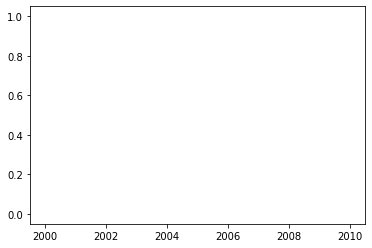

In [211]:
import matplotlib.pyplot as plt

edge_id = 90220037000830029022003700085002

#fig = plt.figure(figsize=(15,10))
#plt.scatter(df.loc[df['Edge'] == edge_id].Timestamp, df.loc[df['Edge'] == edge_id].Delay)
#plt.show(fig)

ax = plt.subplot()
ax.scatter(df.loc[df['Edge'] == edge_id].Timestamp, df.loc[df['Edge'] == edge_id].Delay, color='r')
#ax.set_xlim([datetime.date(2020, 1, 30), datetime.date(2020, 1, 31)])

plt.show()

In [212]:
df.loc[df['Edge'] == 90220037002550019022003700141005]

,Edge,Timestamp,Delay
